In [2]:
import pandas as pd
import numpy as np
import os
import json
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [4]:
results_path = '../output/paper_output/'

In [281]:
pal = sns.color_palette('muted')
hex_pal = pal.as_hex()


# Stage 1 participants

In [299]:
stage1_cw = pd.read_csv(os.path.join(results_path, 'stage1_participant.csv'))
stage1_cw

,_id,prolific_id,study_id,age,gender,english_proficiency,spanish_proficiency,timestamp
0,66c94b29b087a0712a44d22e,6672e1f88167a9b1cdde969a,66c63f4f7c3e886b7c9cc498,36,female,native,intermediate,2024-08-23 22:22:37.119000+00:00
1,66c9d5e7925382be5771897f,66829fd32d471e7ca06e92df,66c90fcc4541f87369be0127,48,male,native,NaN,2024-08-24 12:40:14.128000+00:00
2,66c9d5ff925382be57718980,638070625c26e262f2163254,66c90fcc4541f87369be0127,64,male,native,NaN,2024-08-24 12:40:14.128000+00:00
3,66c9d830925382be57718986,66c97c855434e33b086cc53b,66c90fcc4541f87369be0127,34,female,native,NaN,2024-08-24 12:40:14.128000+00:00
4,66c9d861925382be57718987,6669f862528d0daadf3d2fe6,66c90fcc4541f87369be0127,47,male,native,NaN,2024-08-24 12:40:14.128000+00:00
...,...,...,...,...,...,...,...,...
59,66c5a18086c57a87db6f59dc,5f22932ca6ff8f000918fdfb,66c516b1d61c7b572205f713,33,female,NaN,beginner,2024-08-21 08:04:34.644000+00:00
60,66c5a1cd86c57a87db6f59dd,5ea9a41b87b4150bf9634637,66c516b1d61c7b572205f713,21,female,NaN,intermediate,2024-08-21 08:04:34.644000+00:00
61,66c5a7ac86c57a87db6f5a17,60a0b744298c64d46b63e893,66c516b1d61c7b572205f713,59,female,NaN,beginner,2024-08-21 08:04:34.644000+00:00
62,66c5e3652f44d7b54f76e528,5c068f1f9d0df40001e5688c,66c516b1d61c7b572205f713,33,female,native,NaN,2024-08-21 12:48:03.576000+00:00


In [301]:
stage1_cw['age'].describe().round(2)

count    64.00
mean     34.56
std      13.51
min       6.00
25%      26.00
50%      33.00
75%      43.00
max      71.00
Name: age, dtype: float64

In [300]:
stage1_cw['gender'].value_counts(normalize=True).round(2)*100

gender
female        58.0
male          41.0
non-binary     2.0
Name: proportion, dtype: float64

# stage 1 documents

In [18]:
# documents = pd.read_csv('../data/buckets_combined/master_docs_with_basic_formatting_0109.csv')
documents = pd.read_csv(os.path.join(results_path,'stag1_writing_final.csv'))
# documents['word_count'] = documents['content'].apply(lambda x: len(str(x).split()))
documents.head(1)

,_id,task_id,content,task_category,view_count,word_count,prolific_id
0,66c5a13c86c57a87db6f59d9,ENG,Join hands with us in protecting our planet's ...,ENG,0,193,5a4ff22bacc75b000179b0e9


In [19]:
human_written_task_list = ['ENG','ENG_1', 'ENG_2', 'ESP_1','ESP_2', 'ENG_No_LLM']

In [20]:
documents[documents['task_id'].isin(human_written_task_list)].shape

(96, 7)

In [21]:
documents[documents['task_id'].isin(human_written_task_list)]['word_count'].describe()

count     96.000000
mean     183.864583
std      106.017935
min       71.000000
25%      109.250000
50%      152.500000
75%      223.750000
max      740.000000
Name: word_count, dtype: float64

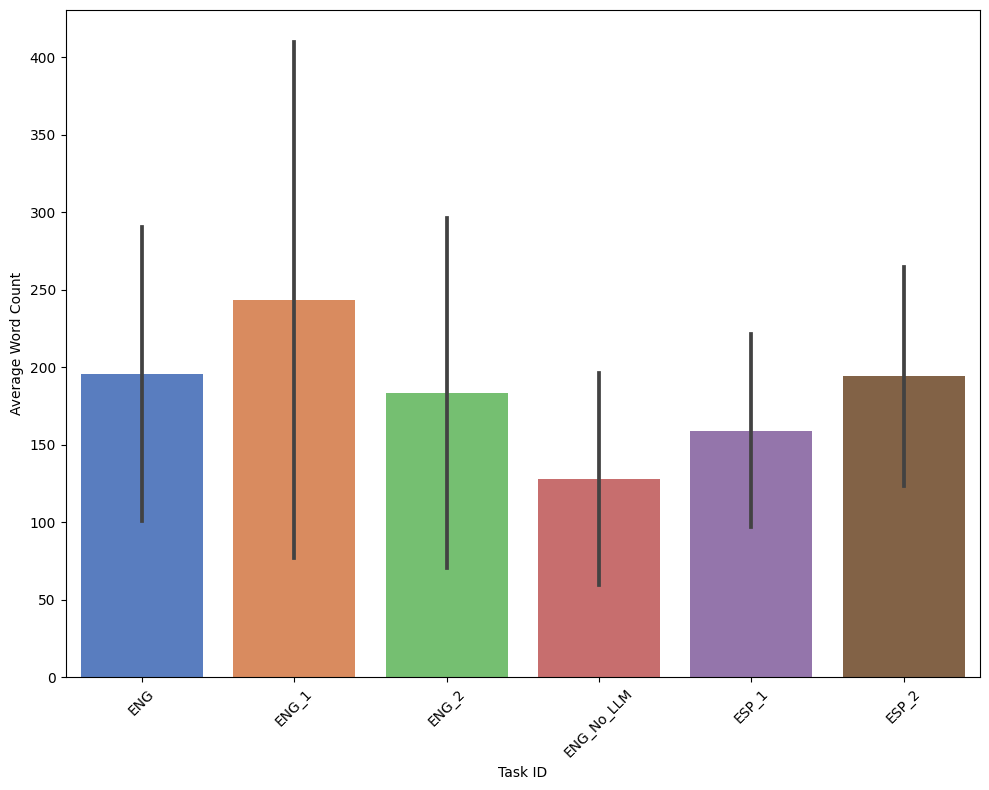

In [26]:
plt.figure(figsize=(10, 8))
sns.barplot(data=documents.sort_values(by='task_id'), x='task_id', y='word_count', errorbar="sd", palette='muted')
# plt.title('Average Word Count by TASK_ID')
plt.ylabel('Average Word Count')
plt.xlabel('Task ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/results/stage1_word_count.pdf')
plt.show()

In [249]:
documents.groupby('task_id')['word_count'].agg(['mean', 'std']).round(2)

,mean,std
task_id,,
ENG,195.56,95.08
ENG_1,243.44,166.55
ENG_2,183.12,112.98
ENG_No_LLM,127.94,68.40
ESP_1,159.06,62.56
ESP_2,194.06,70.81


# Stage 1: Metrics

In [367]:
master_survey_df = pd.read_csv("../data/buckets_combined/master_survey.csv")
# master_documents_df = pd.read_csv('../data/buckets_combined/master_docs_with_basic_formatting_0109.csv')

In [368]:
scale_mapping = {
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5
}

feature_mapping = {
    "FEAT_1": "Variation - Positive Narrative Framing",
    "FEAT_2": "Variation - Cautionary Narrative Framing",
    "FEAT_3": "Variation - Positive Narrative Framing with Statistics",
    "FEAT_4": "Variation - Cautionary Narrative with Statistics",
    "FEAT_5": "Variation - Emphasis on Immediate Outcome",
    "FEAT_6": "Variation - Emphasis on Long-Term Outcome",
    "FEAT_7": "@ai to Generate New Texts",
    "FEAT_8": "Create Continuation"
}

categories = {
    "Ownership": ["OWN_1", "OWN_2", "OWN_3"],
    "Benefits of Co-writing": ["COLAB_1", "COLAB_2", "COLAB_3"],
    "LLM Prowess": ["LM_1", "LM_2", "LM_3", "LM_4"],
}

In [369]:
master_survey_df['responses'] = master_survey_df['responses'].apply(ast.literal_eval)
survey_data = master_survey_df['responses'].tolist()


In [370]:
rows = []

# Process each survey
for _, row in master_survey_df.iterrows():
    survey = row['responses']
    row_data = {}

    # Extract basic information from the original DataFrame
    row_data['PROLIFIC_PID'] = row['prolific_id']
    row_data['STUDY_ID'] = row['study_id']
    row_data['TASK_ID'] = row['TASK_ID']

    # Extract and map ownership responses
    ownership = survey.get('ownership', {})
    for i, key in enumerate(categories['Ownership']):
        row_data[key] = scale_mapping.get(ownership.get(list(ownership.keys())[i], 'NA'), 'NA')

    if row['TASK_ID'] != "ENG_No_LLM":
        # Map collaboration responses
        collaboration = survey.get('collaboration', {})
        for i, key in enumerate(categories['Benefits of Co-writing']):
            row_data[key] = scale_mapping.get(collaboration.get(list(collaboration.keys())[i], 'NA'), 'NA')

        # Map LLM Prowess responses
        aiCapabilities = survey.get('aiCapabilities', {})
        for i, key in enumerate(categories['LLM Prowess']):
            row_data[key] = scale_mapping.get(aiCapabilities.get(list(aiCapabilities.keys())[i], 'NA'), 'NA')

        # Extract and map feature responses (keeping these as they are without scaling)
        usefulness = survey.get('usefulness', {})
        for feat_key, feat_name in feature_mapping.items():
            row_data[feat_key] = usefulness.get(feat_name, 'NA')
    else:
        # If TASK_ID is ENG_No_LLM, set collaboration, LLM Prowess, and feature responses to 'NA'
        for key in categories['Benefits of Co-writing']:
            row_data[key] = 'NA'

        for key in categories['LLM Prowess']:
            row_data[key] = 'NA'

        for feat_key in feature_mapping.keys():
            row_data[feat_key] = 'NA'

    # Append the row_data to the rows list
    rows.append(row_data)

# Create DataFrame with the required columns
final_survey_df = pd.DataFrame(rows, columns=[
    "PROLIFIC_PID", "STUDY_ID", "TASK_ID", 
    "OWN_1", "OWN_2", "OWN_3", 
    "COLAB_1", "COLAB_2", "COLAB_3", 
    "LM_1", "LM_2", "LM_3", "LM_4", 
    "FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", 
    "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8"
])

In [106]:
final_survey_df = final_survey_df.replace('NA', 0)
final_survey_df = final_survey_df.replace('NA', np.nan)
feature_cols = ["FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8"]
features_task = feature_cols + ["TASK_ID"]
for feature in feature_cols:
    final_survey_df[feature] = pd.to_numeric(final_survey_df[feature], errors='coerce')


In [107]:
final_survey_df.head(1)

,PROLIFIC_PID,STUDY_ID,TASK_ID,OWN_1,OWN_2,OWN_3,COLAB_1,COLAB_2,COLAB_3,LM_1,...,LM_3,LM_4,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
0,5a4ff22bacc75b000179b0e9,66c516b1d61c7b572205f713,ENG,1,2,1,4,5,2,5,...,5,5,0,0,0,0,0,0,77,4


In [371]:
final_survey_df.sort_values('TASK_ID', inplace=True)

# Stated Utility

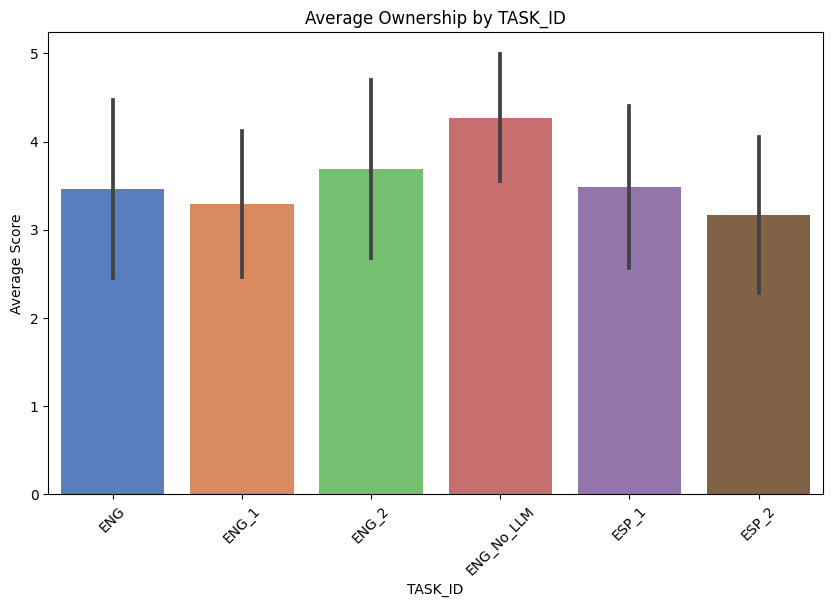

In [373]:
ownership_columns = categories['Ownership']

ownership_df = final_survey_df[ownership_columns + ['TASK_ID']]
ownership_df = ownership_df.copy()

ownership_df.loc[:,'ownsership'] = ownership_df[ownership_columns].mean(axis=1).values
plt.figure(figsize=(10, 6))

# Calculate the mean score for the 'Ownership' category by TASK_ID
sns.barplot(data= ownership_df, x='TASK_ID', y='ownsership', errorbar='sd', palette='muted')
plt.title('Average Ownership by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)
plt.savefig('../figures/results/stage1_ownership.pdf', bbox_inches='tight')
plt.show()


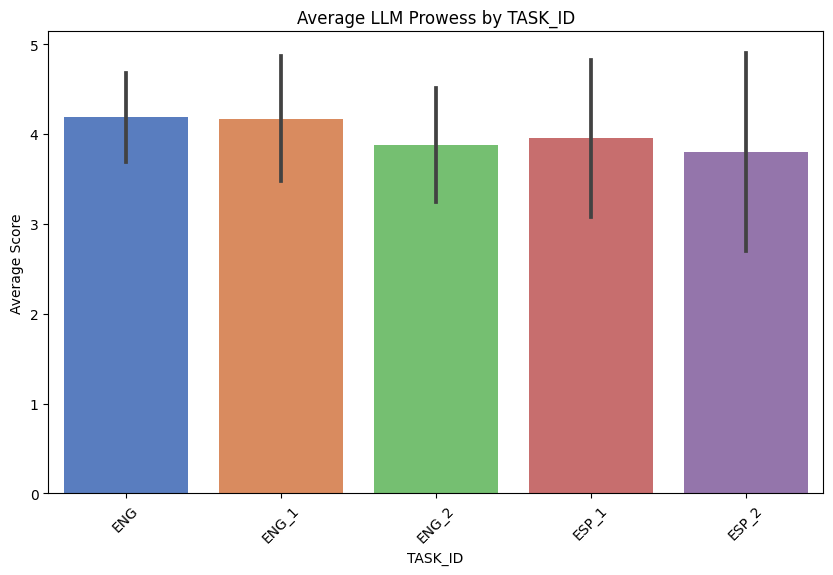

In [381]:
llm_power_cols = categories['LLM Prowess']

llm_power_df = final_survey_df[final_survey_df['TASK_ID']!='ENG_No_LLM'][llm_power_cols + ['TASK_ID']]
llm_power_df = llm_power_df.copy()

llm_power_df.loc[:,'llm_prowess'] = llm_power_df[llm_power_cols].mean(axis=1).values

plt.figure(figsize=(10, 6))
# Calculate the mean score for the 'Ownership' category by TASK_ID
sns.barplot(data= llm_power_df, x='TASK_ID', y='llm_prowess', errorbar='sd',  palette='muted')
plt.title('Average LLM Prowess by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)
plt.savefig('../figures/results/stage1_llm_prowess.pdf', bbox_inches='tight')
plt.show()


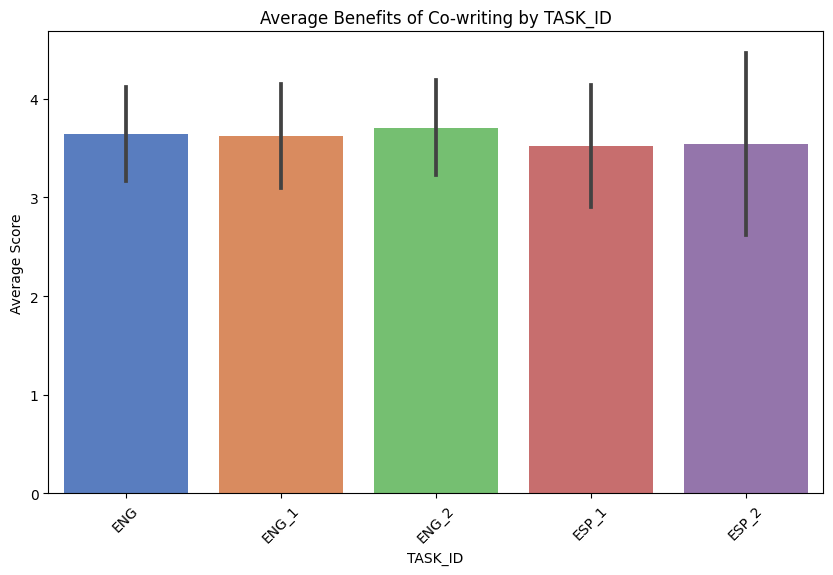

In [382]:
cowriting_cols = categories['Benefits of Co-writing']

cowriting_df = final_survey_df[final_survey_df['TASK_ID']!='ENG_No_LLM'][cowriting_cols + ['TASK_ID']]
cowriting_df = cowriting_df.copy()

cowriting_df.loc[:,'cowriting'] = cowriting_df[cowriting_cols].mean(axis=1).values

plt.figure(figsize=(10, 6))
# Calculate the mean score for the 'Ownership' category by TASK_ID
sns.barplot(data= cowriting_df, x='TASK_ID', y='cowriting', errorbar='sd',  palette='muted')
plt.title('Average Benefits of Co-writing by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)
plt.savefig('../figures/results/stage1_cowriting.pdf', bbox_inches='tight')
plt.show()


In [40]:
final_survey_df[final_survey_df['TASK_ID']=='ENG']['FEAT_1'].describe()

count    16.000000
mean     22.250000
std      35.774292
min       0.000000
25%       0.000000
50%       0.000000
75%      44.750000
max      90.000000
Name: FEAT_1, dtype: float64

# Stated Usefulness

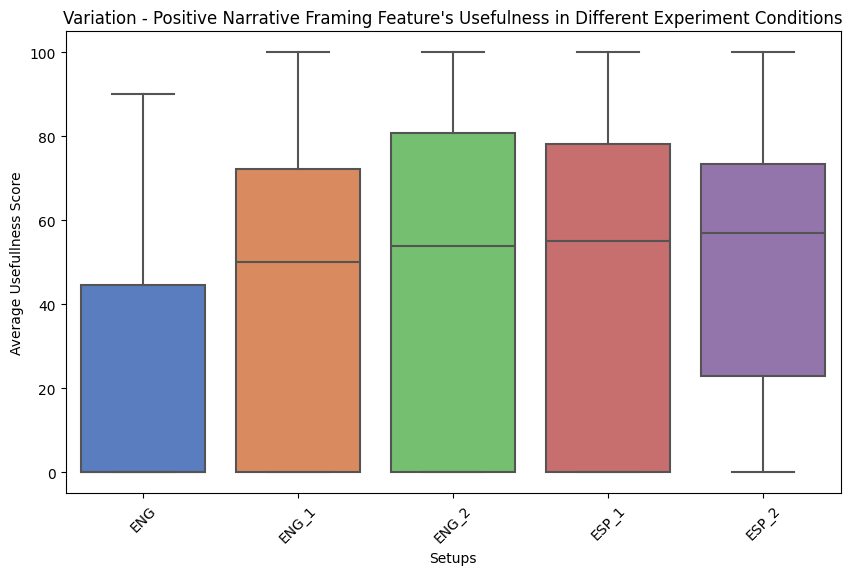

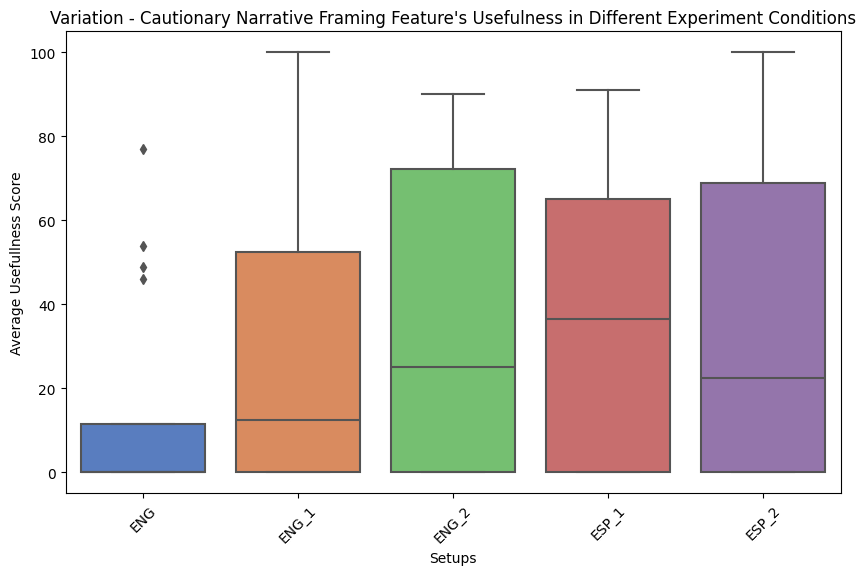

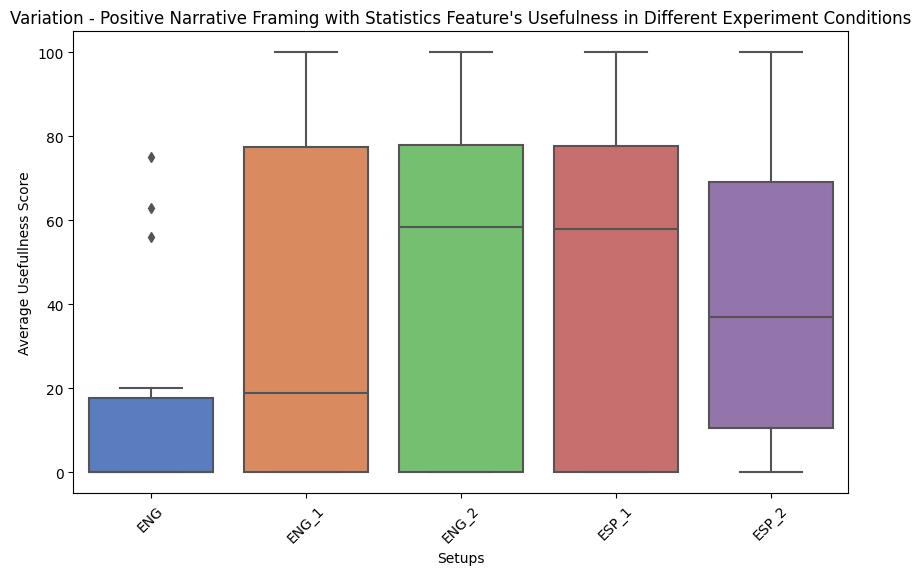

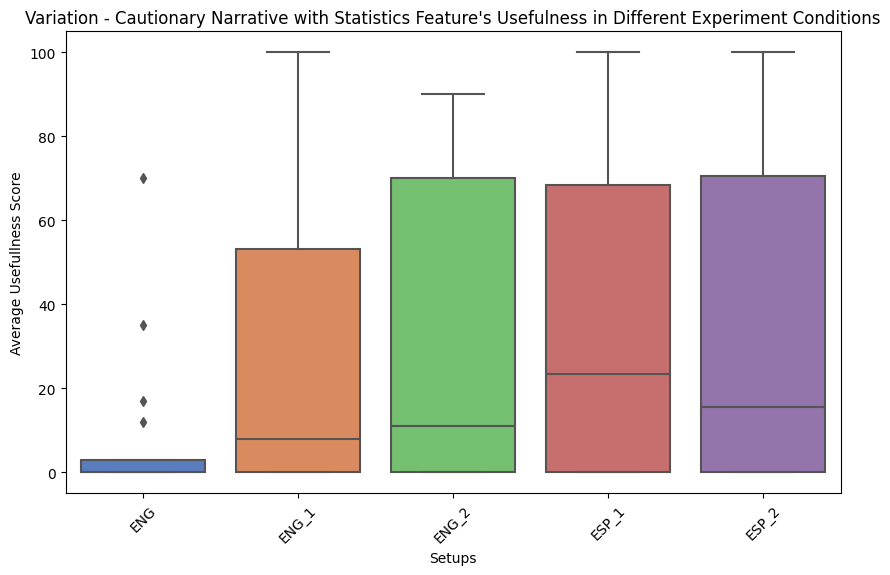

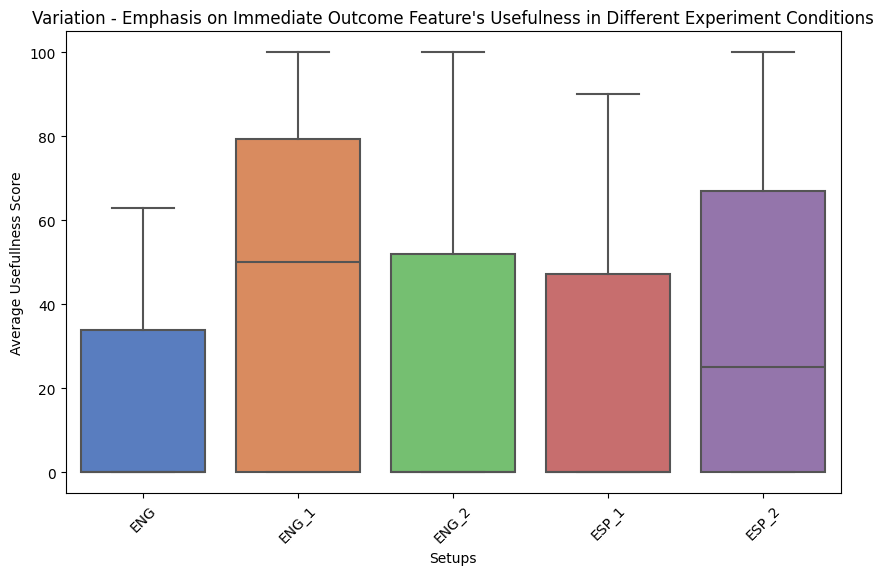

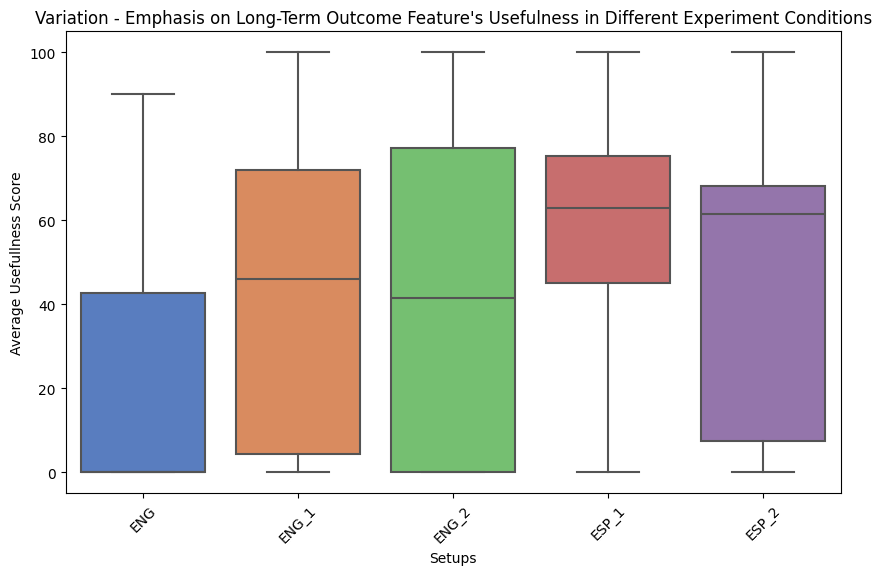

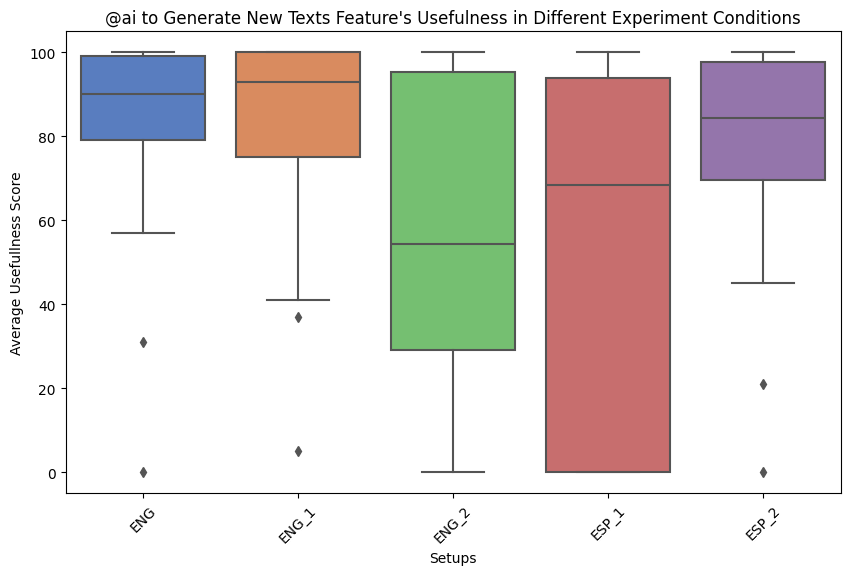

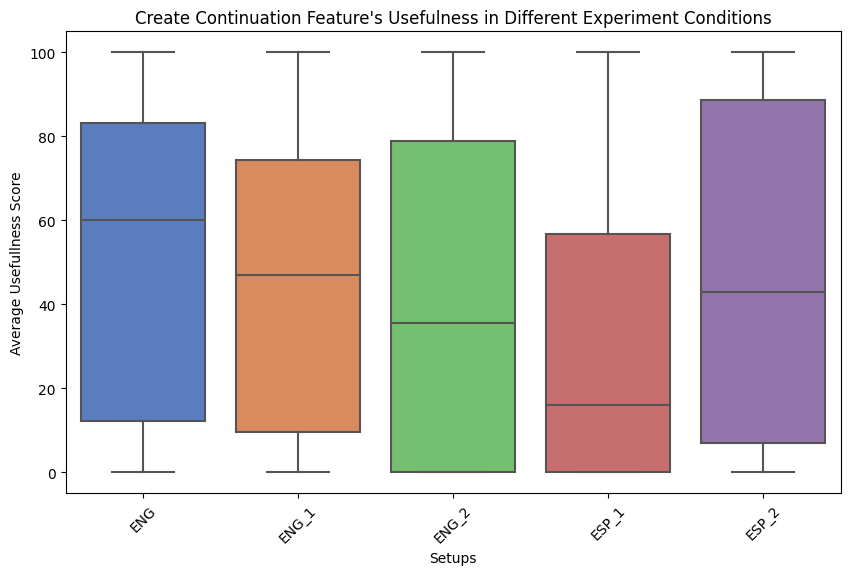

In [108]:
# List of feature columns
# grouped_df = final_survey_df[features_task].groupby('TASK_ID').mean().reset_index()
# grouped_df = grouped_df[grouped_df['TASK_ID']!='ENG_No_LLM']
# List of feature columns
final_survey_df = final_survey_df[final_survey_df['TASK_ID']!='ENG_No_LLM']
# Create a graph for each feature
for feature in feature_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TASK_ID', y=feature, data=final_survey_df, palette='muted')
    plt.title(f'{feature_mapping.get(feature)} Feature\'s Usefulness in Different Experiment Conditions')
    plt.ylabel('Average Usefullness Score')
    plt.xlabel('Setups')
    plt.xticks(rotation=45)
    pdf_filename = f"{feature_mapping.get(feature)}_usefulness_plot.pdf"
    plt.savefig('../figures/results/'+pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()

In [265]:
final_survey_df

,PROLIFIC_PID,STUDY_ID,TASK_ID,OWN_1,OWN_2,OWN_3,COLAB_1,COLAB_2,COLAB_3,LM_1,...,LM_3,LM_4,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
0,5a4ff22bacc75b000179b0e9,66c516b1d61c7b572205f713,ENG,1,2,1,4,5,2,5,...,5,5,0,0,0,0,0,0,77,4
15,66c4960754871133dc3c6b2b,66c516b1d61c7b572205f713,ENG,5,5,5,5,5,2,5,...,3,5,0,0,0,0,0,0,97,99
14,66bf25528e62080ff8342fcc,66c516b1d61c7b572205f713,ENG,5,5,4,4,5,2,4,...,4,5,0,46,0,0,29,41,57,58
13,668f9110575fbd33c0b5d916,66c516b1d61c7b572205f713,ENG,4,4,4,4,4,3,5,...,5,4,62,49,56,70,63,74,80,75
11,6662fad2c34b3fe1216951ae,66c516b1d61c7b572205f713,ENG,4,4,4,4,3,2,4,...,4,4,78,77,63,35,61,48,99,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,6118640de60c5ad39bdfbf95,66c616da5ea4ebca7f461ac7,ESP_2,3,4,3,5,4,3,4,...,4,4,67,69,69,67,66,67,86,10
43,6140c26c2ee391b3f4601f01,66c616da5ea4ebca7f461ac7,ESP_2,2,3,2,4,4,4,4,...,3,4,87,0,61,0,0,46,77,0
45,5e8a0912524dca6ad71ecb86,66c616da5ea4ebca7f461ac7,ESP_2,5,4,1,5,5,5,5,...,5,5,7,16,22,0,0,0,71,4
27,668afb2dcc141c65a49592dd,66c5e9afb11bf5c62a286fe8,ESP_2,4,4,4,4,4,3,4,...,4,4,49,0,0,29,28,58,83,65


# Revealed Uility - Feature usage count

In [64]:
master_activity_df = pd.read_csv("../data/buckets_combined/master_activity.csv")
master_activity_df['activity_log'] = master_activity_df['activity_log'].apply(ast.literal_eval)



In [65]:
master_activity_df['generated'] = master_activity_df['activity_log'].apply(lambda x: x['generatedContent'])

In [268]:
master_activity_df

,_id,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,generated
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,"[{'feature': '@ai generation', 'prompt': 'writ..."
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,[{'feature': 'Cautionary Narrative with Statis...
2,66c5a2ec86c57a87db6f59ed,66c5a21086c57a87db6f59e1,main_task_1,5c62de3f48fe4e000180e09d,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:18:52.061000+00:00,66c516b1d61c7b572205f713,ENG,"[{'feature': '@ai generation', 'prompt': 'plea..."
3,66c88800e46942c099b32394,66c88773e46942c099b32393,main_task_1,5d1f9776676cd1001580ae9c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-23 13:00:48.591000+00:00,66c516b1d61c7b572205f713,ENG,"[{'feature': '@ai generation', 'prompt': 'use ..."
4,66c5a5c486c57a87db6f5a00,66c5a3e386c57a87db6f59f9,main_task_1,5ea9a41b87b4150bf9634637,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:31:00.305000+00:00,66c516b1d61c7b572205f713,ENG,"[{'feature': '@ai generation', 'prompt': ' ﻿Wr..."
...,...,...,...,...,...,...,...,...,...,...
91,66c9e020925382be577189bb,66c9dc59925382be577189b5,main_task_1,60897f81d4a682307c628739,"{'buttonClicks': [], 'generatedContent': [], '...",12800,2024-08-24 13:29:04.194000+00:00,66c90fcc4541f87369be0127,ENG_No_LLM,[]
92,66c9e04f925382be577189be,66c9dbe4925382be577189af,main_task_1,66a3b18c58afbaf406f6ed4a,"{'buttonClicks': [], 'generatedContent': [], '...",12560,2024-08-24 13:29:51.324000+00:00,66c90fcc4541f87369be0127,ENG_No_LLM,[]
93,66c9e11b925382be577189c1,66c9da27925382be5771899c,main_task_1,6676842beee8713bc1b33408,"{'buttonClicks': [], 'generatedContent': [], '...",12750,2024-08-24 13:33:15.492000+00:00,66c90fcc4541f87369be0127,ENG_No_LLM,[]
94,66c9f25b925382be577189c9,66c9f03a925382be577189c6,main_task_1,5efc4a5bed804f20d1c1b0f4,"{'buttonClicks': [], 'generatedContent': [], '...",0,2024-08-24 14:46:51.777000+00:00,66c90fcc4541f87369be0127,ENG_No_LLM,[]


In [269]:
usage_count_data = []
for _, row in master_activity_df.iterrows():
    # plain_text = row['plain_text']
    generated_content = row['generated']
    task_id = row['TASK_ID']
    document_id = row['document_id']
    # for content in generated_content:
    counter = Counter(content.get('feature', 'custom recipe') for content in generated_content)
    for feat, cnt in counter.items():
        usage_count_data.append(
            {
                'task_id': task_id,
                'feature': feat,
                'document_id': document_id,
                'count': cnt,
            }
        )
        
    # weighted_similarity = calculate_weighted_similarity(plain_text, generated_content, model)
    # weighted_similarity_results.append(weighted_similarity)

In [270]:
usage_count_df = pd.DataFrame(usage_count_data)
usage_count_df['feature'].unique()

array(['@ai generation', 'Positive Narrative Framing',
       'Emphasis on Long-Term Outcome',
       'Cautionary Narrative with Statistics',
       'Positive Narrative Framing with Statistics',
       'Emphasis on Immediate Outcome', 'Cautionary Narrative Framing',
       'continuation', 'newly created recipe', 'Emotional Manipulation',
       'custom recipe', 'Summary: ADD STATISTICS', 'Be More Emotional'],
      dtype=object)

In [271]:
usage_count_df

,task_id,feature,document_id,count
0,ENG,@ai generation,66c5a13c86c57a87db6f59d9,1
1,ENG,Positive Narrative Framing,66c5a13c86c57a87db6f59d9,3
2,ENG,Emphasis on Long-Term Outcome,66c5a13c86c57a87db6f59d9,1
3,ENG,Cautionary Narrative with Statistics,66c5e4be2f44d7b54f76e52d,1
4,ENG,Positive Narrative Framing with Statistics,66c5e4be2f44d7b54f76e52d,2
...,...,...,...,...
296,ENG_2,Positive Narrative Framing with Statistics,66c750f16db9c208f260cc18,1
297,ENG_2,Cautionary Narrative with Statistics,66c750f16db9c208f260cc18,1
298,ENG_2,Emphasis on Immediate Outcome,66c750f16db9c208f260cc18,1
299,ENG_2,Emphasis on Long-Term Outcome,66c750f16db9c208f260cc18,1


In [272]:
usage_count_df.to_csv('./t.csv',index=False)

In [68]:
usage_names_list = [
    "continuation",
    "@ai generation",
    "Positive Narrative Framing",
    "Cautionary Narrative Framing",
    "Positive Narrative Framing with Statistics",
    "Cautionary Narrative with Statistics",
    "Emphasis on Immediate Outcome",
    "Emphasis on Long-Term Outcome"
]

In [69]:
usage_count_df['feature_filtered'] = usage_count_df['feature'].apply(
    lambda x: x if x in usage_names_list else 'custom'
)

In [267]:
usage_count_df

,task_id,feature,count,feature_filtered
0,ENG,@ai generation,1,@ai generation
1,ENG,Positive Narrative Framing,3,Positive Narrative Framing
2,ENG,Emphasis on Long-Term Outcome,1,Emphasis on Long-Term Outcome
3,ENG,Cautionary Narrative with Statistics,1,Cautionary Narrative with Statistics
4,ENG,Positive Narrative Framing with Statistics,2,Positive Narrative Framing with Statistics
...,...,...,...,...
296,ENG_2,Positive Narrative Framing with Statistics,1,Positive Narrative Framing with Statistics
297,ENG_2,Cautionary Narrative with Statistics,1,Cautionary Narrative with Statistics
298,ENG_2,Emphasis on Immediate Outcome,1,Emphasis on Immediate Outcome
299,ENG_2,Emphasis on Long-Term Outcome,1,Emphasis on Long-Term Outcome


In [70]:
usage_count_grouped = usage_count_df.groupby(['task_id', 'feature_filtered'])['count'].sum().reset_index()
# usage_count_grouped_without_eng = usage_count_grouped[usage_count_grouped['task_id']!='ENG']
usage_count_grouped_without_eng = usage_count_grouped[usage_count_grouped['feature_filtered']!='custom']
heatmap_data_feature_usage = usage_count_grouped_without_eng.pivot(index="feature_filtered", columns="task_id", values="count")

In [282]:
heatmap_data_feature_usage

task_id,ENG,ENG_1,ENG_2,ESP_1,ESP_2
feature_filtered,,,,,
@ai generation,30,28,10,9,27
Cautionary Narrative Framing,12,9,7,5,6
Cautionary Narrative with Statistics,11,8,13,7,10
Emphasis on Immediate Outcome,13,12,10,7,4
Emphasis on Long-Term Outcome,18,10,6,17,7
Positive Narrative Framing,31,21,10,14,14
Positive Narrative Framing with Statistics,15,11,8,7,12
continuation,10,7,8,8,15


In [87]:
fig = px.imshow(heatmap_data_feature_usage, 
                labels=dict(x="Task ID", y="Features", color="Count"),
                x=heatmap_data_feature_usage.columns,
                y=heatmap_data_feature_usage.index,
                color_continuous_scale="Viridis",  # Professional color scale
                text_auto=True,  # Adds annotations
                aspect='auto')

# Improve layout: adjust title, axis labels, and font sizes
fig.update_layout(
    title={
        'text': "Heatmap of Feature Counts by Task ID",
        'y': 0.95,  # Title positioning
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Task ID",
    yaxis_title="Features",
    font=dict(size=16),  # Increase font size
    width=1200,
    height=800,
    margin=dict(l=80, r=80, t=100, b=80),  # Adjust margins
)

# Subtle gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Adjust color bar (optional)
fig.update_coloraxes(colorbar_title_side='right', colorbar_tickangle=-45)

# Increase resolution for publications by exporting the image
# fig.write_image("heatmap_high_res.png", scale=2)  # Export in high resolution

# Show the plot
fig.show()

# Trend chart

In [285]:
data = {
    'feature_filtered': ['@ai generation', 'Cautionary Narrative Framing', 'Cautionary Narrative with Statistics', 
                         'Emphasis on Immediate Outcome', 'Emphasis on Long-Term Outcome', 'Positive Narrative Framing', 
                         'Positive Narrative Framing with Statistics', 'continuation'],
    'ENG': [30, 12, 11, 13, 18, 31, 15, 10],
    'ENG_1': [28, 9, 8, 12, 10, 21, 11, 7],
    'ENG_2': [10, 7, 13, 10, 6, 10, 8, 8],
    'ESP_1': [9, 5, 7, 7, 17, 14, 7, 8],
    'ESP_2': [27, 6, 10, 4, 7, 14, 12, 15]
}

df = pd.DataFrame(data)

# Calculating the total for each column
df_totals = df[['ENG', 'ENG_1', 'ENG_2', 'ESP_1', 'ESP_2']].sum()

# Calculating the revealed preference score by normalizing the usage counts
df_normalized = df.set_index('feature_filtered').div(df_totals, axis=1)
df_normalized

,ENG,ENG_1,ENG_2,ESP_1,ESP_2
feature_filtered,,,,,
@ai generation,0.214286,0.264151,0.138889,0.121622,0.284211
Cautionary Narrative Framing,0.085714,0.084906,0.097222,0.067568,0.063158
Cautionary Narrative with Statistics,0.078571,0.075472,0.180556,0.094595,0.105263
Emphasis on Immediate Outcome,0.092857,0.113208,0.138889,0.094595,0.042105
Emphasis on Long-Term Outcome,0.128571,0.094340,0.083333,0.229730,0.073684
Positive Narrative Framing,0.221429,0.198113,0.138889,0.189189,0.147368
Positive Narrative Framing with Statistics,0.107143,0.103774,0.111111,0.094595,0.126316
continuation,0.071429,0.066038,0.111111,0.108108,0.157895


In [286]:
# Creating a dataframe with each task group, each feature, and its corresponding preference score
preference_scores = df_normalized.reset_index().melt(id_vars='feature_filtered', var_name='Task Group', value_name='Preference Score')
preference_scores

,feature_filtered,Task Group,Preference Score
0,@ai generation,ENG,0.214286
1,Cautionary Narrative Framing,ENG,0.085714
2,Cautionary Narrative with Statistics,ENG,0.078571
3,Emphasis on Immediate Outcome,ENG,0.092857
4,Emphasis on Long-Term Outcome,ENG,0.128571
5,Positive Narrative Framing,ENG,0.221429
6,Positive Narrative Framing with Statistics,ENG,0.107143
7,continuation,ENG,0.071429
8,@ai generation,ENG_1,0.264151
9,Cautionary Narrative Framing,ENG_1,0.084906


In [290]:
df_normalized.columns

Index(['ENG', 'ENG_1', 'ENG_2', 'ESP_1', 'ESP_2'], dtype='object')

In [291]:
eng_groups = ['ENG', 'ENG_1', 'ENG_2']
esp_groups = ['ESP_1', 'ESP_2']

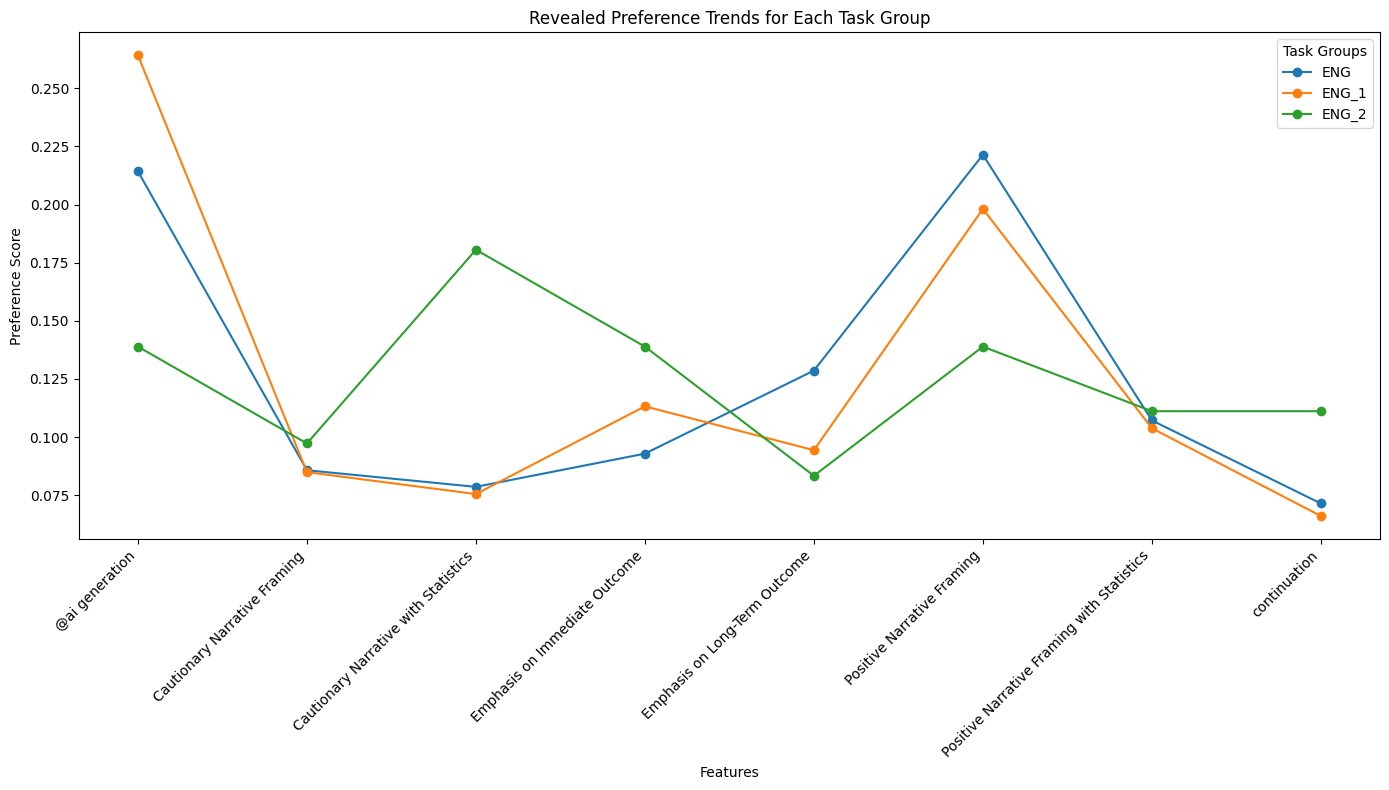

In [295]:
plt.figure(figsize=(14, 8))

for task_group in eng_groups:
    plt.plot(df_normalized.index, df_normalized[task_group], marker='o', label=task_group)

plt.title('Revealed Preference Trends for Each Task Group')
plt.xlabel('Features')
plt.ylabel('Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Groups')
plt.tight_layout()
plt.savefig('../figures/results/stag1_eng_count_trend.pdf')
plt.show()

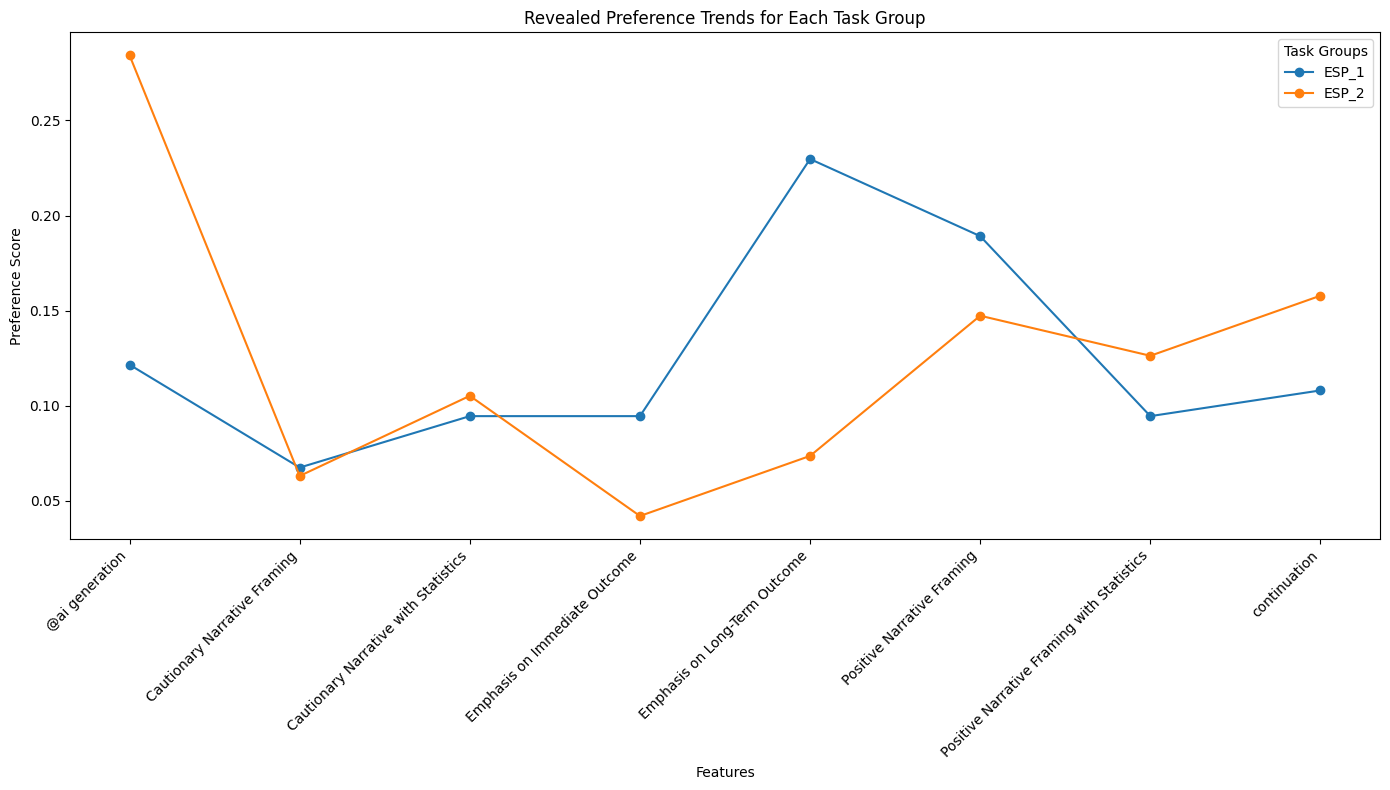

In [296]:
plt.figure(figsize=(14, 8))

for task_group in esp_groups:
    plt.plot(df_normalized.index, df_normalized[task_group], marker='o', label=task_group)

plt.title('Revealed Preference Trends for Each Task Group')
plt.xlabel('Features')
plt.ylabel('Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Groups')
plt.tight_layout()
plt.savefig('../figures/results/stag1_esp_count_trend.pdf')
plt.show()

# Stated Utility Trend

In [328]:
stated_preferences = final_survey_df[feature_cols + ['TASK_ID']]
stated_preferences

,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8,TASK_ID
0,0,0,0,0,0,0,77,4,ENG
15,0,0,0,0,0,0,97,99,ENG
14,0,46,0,0,29,41,57,58,ENG
13,62,49,56,70,63,74,80,75,ENG
11,78,77,63,35,61,48,99,96,ENG
...,...,...,...,...,...,...,...,...,...
41,67,69,69,67,66,67,86,10,ESP_2
43,87,0,61,0,0,46,77,0,ESP_2
45,7,16,22,0,0,0,71,4,ESP_2
27,49,0,0,29,28,58,83,65,ESP_2


In [329]:
stated_preferences_grouped = stated_preferences.groupby('TASK_ID').mean()
stated_preferences_grouped

,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
TASK_ID,,,,,,,,
ENG,22.2500,14.1250,14.4375,8.3750,17.8750,22.2500,80.1250,51.5625
ENG_1,43.6875,30.1875,37.0000,30.3750,43.1250,42.6875,80.8125,45.1875
ENG_2,43.4375,35.6250,44.6875,33.0625,26.8125,38.9375,55.1250,41.5000
ESP_1,45.3750,38.0000,43.7500,35.8125,22.6875,55.0000,55.6250,32.0625
ESP_2,50.2500,34.0625,41.5000,34.6875,36.9375,48.1250,75.3750,46.5625


In [330]:
stated_preferences_grouped.sum(axis=1)

TASK_ID
ENG      231.0000
ENG_1    353.0625
ENG_2    319.1875
ESP_1    328.3125
ESP_2    367.5000
dtype: float64

In [331]:
stated_preferences_normalized = stated_preferences_grouped.div(stated_preferences_grouped.sum(axis=1), axis=0)
stated_preferences_normalized

,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
TASK_ID,,,,,,,,
ENG,0.096320,0.061147,0.062500,0.036255,0.077381,0.096320,0.346861,0.223214
ENG_1,0.123739,0.085502,0.104797,0.086033,0.122146,0.120906,0.228890,0.127987
ENG_2,0.136088,0.111612,0.140004,0.103583,0.084002,0.121989,0.172704,0.130018
ESP_1,0.138207,0.115743,0.133257,0.109081,0.069103,0.167523,0.169427,0.097658
ESP_2,0.136735,0.092687,0.112925,0.094388,0.100510,0.130952,0.205102,0.126701


In [332]:
eng_groups = ['ENG', 'ENG_1', 'ENG_2']
esp_groups = ['ESP_1', 'ESP_2']

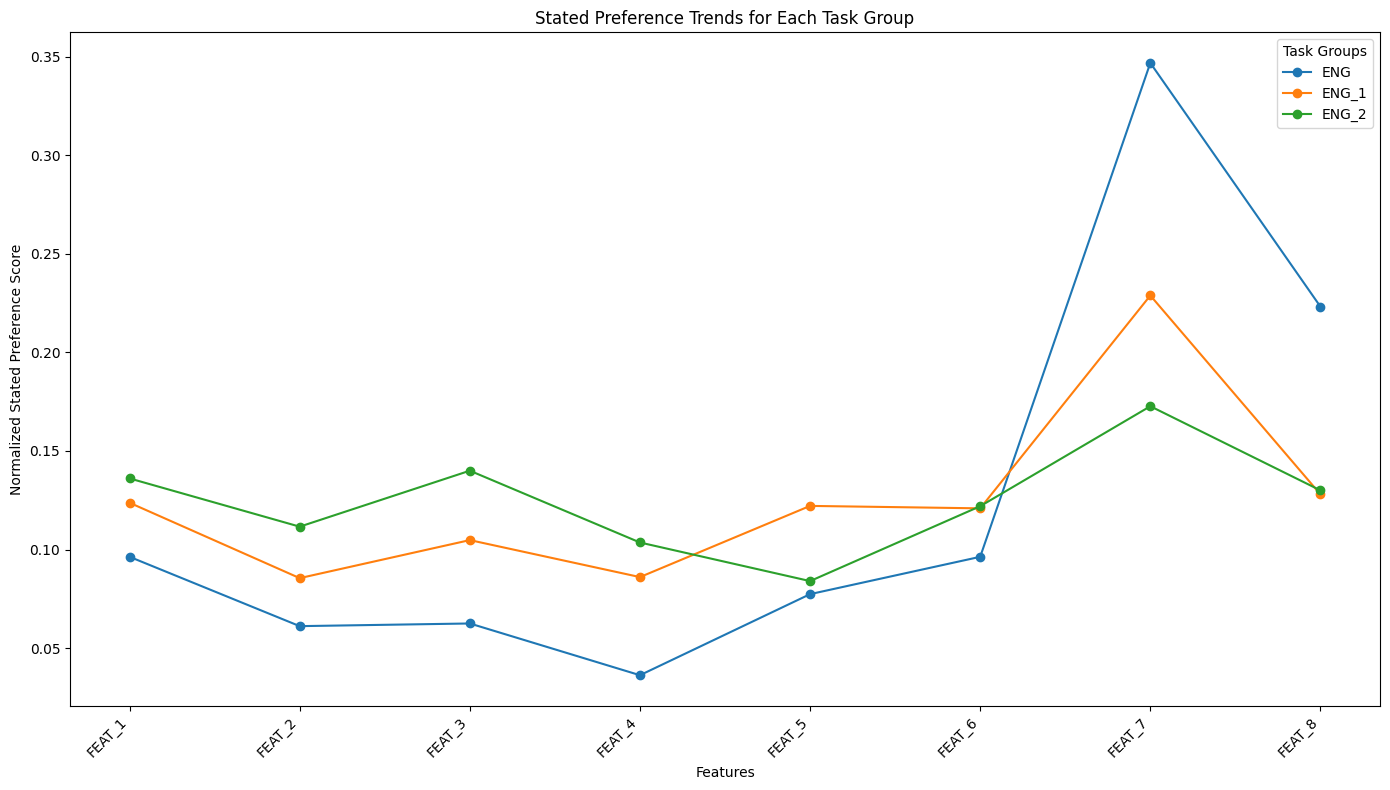

In [335]:
plt.figure(figsize=(14, 8))

for task_group in eng_groups:
    plt.plot(stated_preferences_normalized.columns, stated_preferences_normalized.loc[task_group], marker='o', label=task_group)

plt.title('Stated Preference Trends for Each Task Group')
plt.xlabel('Features')
plt.ylabel('Normalized Stated Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Groups')
plt.tight_layout()

plt.show()

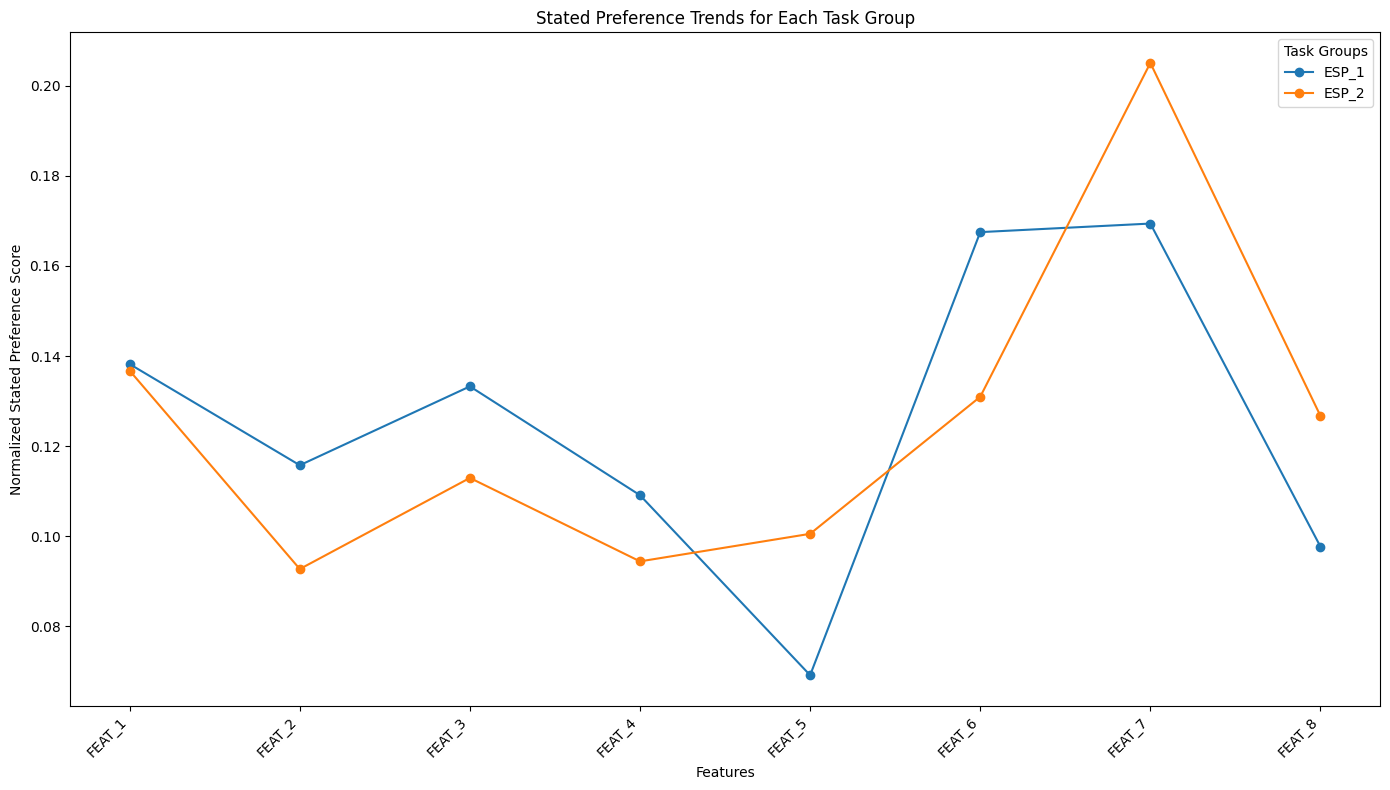

In [326]:
plt.figure(figsize=(14, 8))

for task_group in esp_groups:
    plt.plot(stated_preferences_normalized.columns, stated_preferences_normalized.loc[task_group], marker='o', label=task_group)

plt.title('Stated Preference Trends for Each Task Group')
plt.xlabel('Features')
plt.ylabel('Normalized Stated Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Groups')
plt.tight_layout()

plt.show()

In [334]:
stated_preferences_normalized.loc[eng_groups].mean()

FEAT_1    0.118716
FEAT_2    0.086087
FEAT_3    0.102434
FEAT_4    0.075291
FEAT_5    0.094510
FEAT_6    0.113072
FEAT_7    0.249485
FEAT_8    0.160406
dtype: float64

In [ ]:
# Plotting two separate charts for ENG-based and ESP-based task groups

# Grouping ENG-based and ESP-based task groups
eng_groups = ['ENG', 'ENG_1', 'ENG_2']
esp_groups = ['ESP_1', 'ESP_2']

# Calculating the mean stated preferences for each group
eng_stated_preferences = stated_preferences_normalized.loc[eng_groups].mean()
esp_stated_preferences = stated_preferences_normalized.loc[esp_groups].mean()

# # Plotting the grouped stated preferences
# plt.figure(figsize=(14, 8))

# plt.plot(eng_stated_preferences.index, eng_stated_preferences.values, marker='o', label='ENG-based', color='blue')
# plt.plot(esp_stated_preferences.index, esp_stated_preferences.values, marker='o', label='ESP-based', color='green')

# plt.title('Grouped Stated Preference Trends (ENG-based vs ESP-based)')
# plt.xlabel('Features')
# plt.ylabel('Normalized Stated Preference Score')
# plt.xticks(rotation=45, ha='right')
# plt.legend(title='Group')
# plt.tight_layout()

# plt.show()


# ENG-based plot
plt.figure(figsize=(14, 6))
plt.plot(eng_stated_preferences.index, stated_preferences_normalized.loc['ENG'], marker='o', label='ENG', color='blue')
plt.plot(eng_stated_preferences.index, stated_preferences_normalized.loc['ENG_1'], marker='o', label='ENG_1', color='orange')
plt.plot(eng_stated_preferences.index, stated_preferences_normalized.loc['ENG_2'], marker='o', label='ENG_2', color='green')

plt.title('Stated Preference Trends (ENG, ENG_1, ENG_2)')
plt.xlabel('Features')
plt.ylabel('Normalized Stated Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Group')
plt.tight_layout()
plt.show()

# ESP-based plot
plt.figure(figsize=(14, 6))
plt.plot(esp_stated_preferences.index, stated_preferences_normalized.loc['ESP_1'], marker='o', label='ESP_1', color='red')
plt.plot(esp_stated_preferences.index, stated_preferences_normalized.loc['ESP_2'], marker='o', label='ESP_2', color='purple')

plt.title('Stated Preference Trends (ESP_1, ESP_2)')
plt.xlabel('Features')
plt.ylabel('Normalized Stated Preference Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Task Group')
plt.tight_layout()
plt.show()


In [110]:
heatmap_data_feature_usage

task_id,ENG,ENG_1,ENG_2,ESP_1,ESP_2
feature_filtered,,,,,
@ai generation,30,28,10,9,27
Cautionary Narrative Framing,12,9,7,5,6
Cautionary Narrative with Statistics,11,8,13,7,10
Emphasis on Immediate Outcome,13,12,10,7,4
Emphasis on Long-Term Outcome,18,10,6,17,7
Positive Narrative Framing,31,21,10,14,14
Positive Narrative Framing with Statistics,15,11,8,7,12
continuation,10,7,8,8,15


In [111]:
# heatmap_data_feature_usage.set_index('feature_filtered', inplace=True)

# Calculate the percentage of each feature usage for each task
percentage_feature_usage = heatmap_data_feature_usage.div(heatmap_data_feature_usage.sum(axis=0), axis=1) * 100
# percentage_feature_usage
percentage_feature_usage.round(2).map(lambda x: f'{x}%')


task_id,ENG,ENG_1,ENG_2,ESP_1,ESP_2
feature_filtered,,,,,
@ai generation,21.43%,26.42%,13.89%,12.16%,28.42%
Cautionary Narrative Framing,8.57%,8.49%,9.72%,6.76%,6.32%
Cautionary Narrative with Statistics,7.86%,7.55%,18.06%,9.46%,10.53%
Emphasis on Immediate Outcome,9.29%,11.32%,13.89%,9.46%,4.21%
Emphasis on Long-Term Outcome,12.86%,9.43%,8.33%,22.97%,7.37%
Positive Narrative Framing,22.14%,19.81%,13.89%,18.92%,14.74%
Positive Narrative Framing with Statistics,10.71%,10.38%,11.11%,9.46%,12.63%
continuation,7.14%,6.6%,11.11%,10.81%,15.79%


In [161]:
feature_usage = heatmap_data_feature_usage.sum(axis=1)
total_feature_usage = feature_usage.sum()
percentage_feature_usage = (feature_usage / total_feature_usage) * 100
percentage_feature_usage = percentage_feature_usage.reset_index().rename(columns={0:'percentage'})
percentage_feature_usage.sort_values('percentage', ascending=False, inplace=True)
percentage_feature_usage

,feature_filtered,percentage
0,@ai generation,21.355236
5,Positive Narrative Framing,18.480493
4,Emphasis on Long-Term Outcome,11.909651
6,Positive Narrative Framing with Statistics,10.882957
2,Cautionary Narrative with Statistics,10.061602
7,continuation,9.856263
3,Emphasis on Immediate Outcome,9.445585
1,Cautionary Narrative Framing,8.008214


In [336]:
usage_percentage = {
    "@ai generation": 21.355236,
    "Positive Narrative Framing": 18.480493,
    "Emphasis on Long-Term Outcome": 11.909651,
    "Positive Narrative Framing with Statistics": 10.882957,
    "Cautionary Narrative with Statistics": 10.061602,
    "Cautionary Narrative Framing": 8.008214,
    "Emphasis on Immediate Outcome": 9.445585,
    "continuation": 9.856263
}

In [385]:
[round(perc,2) for perc in usage_percentage.values()]

[21.36, 18.48, 11.91, 10.88, 10.06, 8.01, 9.45, 9.86]

In [337]:
feat_to_full_name = {
    "FEAT_7": "@ai generation",
    "FEAT_1": "Positive Narrative Framing",
    "FEAT_6": "Emphasis on Long-Term Outcome",
    "FEAT_3": "Positive Narrative Framing with Statistics",
    "FEAT_4": "Cautionary Narrative with Statistics",
    "FEAT_8": "continuation",
    "FEAT_5": "Emphasis on Immediate Outcome",
    "FEAT_2": "Cautionary Narrative Framing"
}

In [339]:
stated_preferences_normalized

,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
TASK_ID,,,,,,,,
ENG,0.096320,0.061147,0.062500,0.036255,0.077381,0.096320,0.346861,0.223214
ENG_1,0.123739,0.085502,0.104797,0.086033,0.122146,0.120906,0.228890,0.127987
ENG_2,0.136088,0.111612,0.140004,0.103583,0.084002,0.121989,0.172704,0.130018
ESP_1,0.138207,0.115743,0.133257,0.109081,0.069103,0.167523,0.169427,0.097658
ESP_2,0.136735,0.092687,0.112925,0.094388,0.100510,0.130952,0.205102,0.126701


In [340]:
stated_preferences_normalized_renamed = stated_preferences_normalized.rename(columns=feat_to_full_name)
stated_preferences_normalized_renamed

,Positive Narrative Framing,Cautionary Narrative Framing,Positive Narrative Framing with Statistics,Cautionary Narrative with Statistics,Emphasis on Immediate Outcome,Emphasis on Long-Term Outcome,@ai generation,continuation
TASK_ID,,,,,,,,
ENG,0.096320,0.061147,0.062500,0.036255,0.077381,0.096320,0.346861,0.223214
ENG_1,0.123739,0.085502,0.104797,0.086033,0.122146,0.120906,0.228890,0.127987
ENG_2,0.136088,0.111612,0.140004,0.103583,0.084002,0.121989,0.172704,0.130018
ESP_1,0.138207,0.115743,0.133257,0.109081,0.069103,0.167523,0.169427,0.097658
ESP_2,0.136735,0.092687,0.112925,0.094388,0.100510,0.130952,0.205102,0.126701


In [345]:
usage_percentage

{'@ai generation': 21.355236,
 'Positive Narrative Framing': 18.480493,
 'Emphasis on Long-Term Outcome': 11.909651,
 'Positive Narrative Framing with Statistics': 10.882957,
 'Cautionary Narrative with Statistics': 10.061602,
 'Cautionary Narrative Framing': 8.008214,
 'Emphasis on Immediate Outcome': 9.445585,
 'continuation': 9.856263}

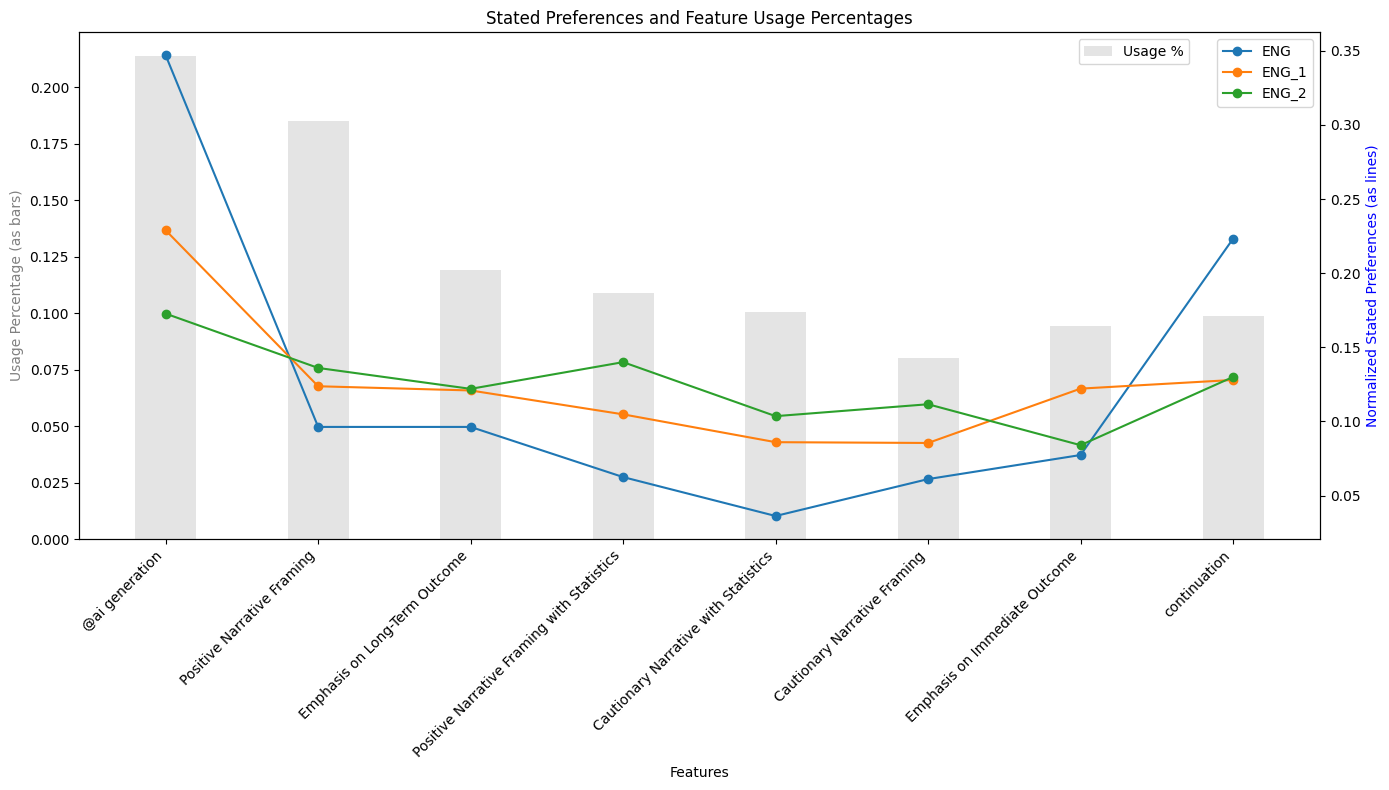

In [357]:

# Reorder stated_preferences_normalized_renamed to match usage_percentage order
ordered_columns = list(usage_percentage.keys())
stated_preferences_normalized_ordered = stated_preferences_normalized_renamed[ordered_columns]

# Create a new figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bar chart for percentage usage
bar_positions = np.arange(len(usage_percentage.keys()))  # Set positions for the bars
ax1.bar(bar_positions, [v / 100 for v in usage_percentage.values()], color='lightgray', width=0.4, label='Usage %', alpha=0.6)

# Set the x-tick labels to feature names
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(ordered_columns, rotation=45, ha='right')

# Plot the lines for normalized stated preferences
ax2 = ax1.twinx()
for task_group in eng_groups:
    ax2.plot(bar_positions, stated_preferences_normalized_ordered.loc[task_group], marker='o', label=task_group)

# Set labels and title
ax1.set_xlabel('Features')
ax1.set_ylabel('Usage Percentage (as bars)', color='gray')
ax2.set_ylabel('Normalized Stated Preferences (as lines)', color='blue')

# Adjust the title
plt.title('Stated Preferences and Feature Usage Percentages')

# Combine legends from both plots
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.savefig('../figures/results/stated_preferences_and_usage_eng.pdf', bbox_inches='tight')
# Make layout tight for better formatting
plt.tight_layout()

# Show the plot
plt.show()


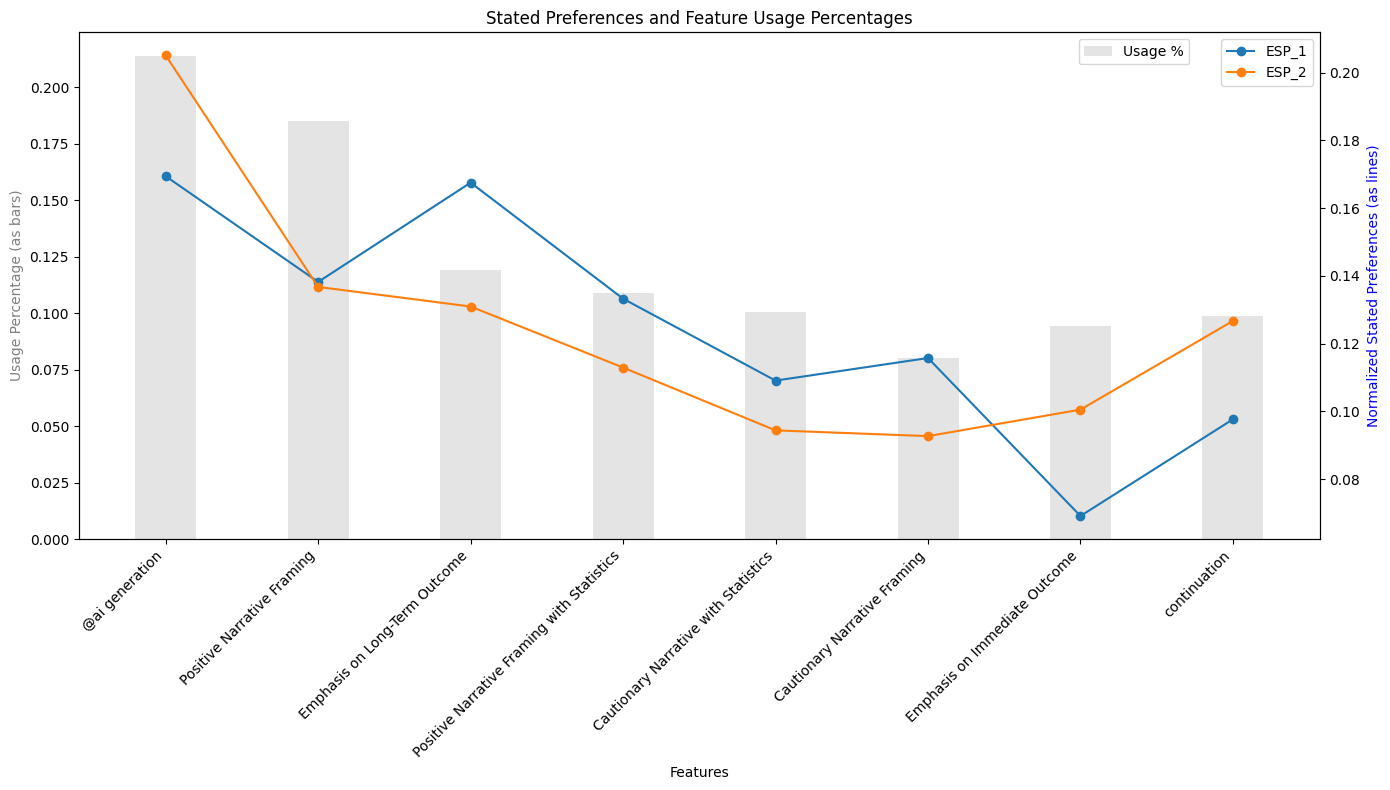

In [358]:

# Reorder stated_preferences_normalized_renamed to match usage_percentage order
ordered_columns = list(usage_percentage.keys())
stated_preferences_normalized_ordered = stated_preferences_normalized_renamed[ordered_columns]

# Create a new figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bar chart for percentage usage
bar_positions = np.arange(len(usage_percentage.keys()))  # Set positions for the bars
ax1.bar(bar_positions, [v / 100 for v in usage_percentage.values()], color='lightgray', width=0.4, label='Usage %', alpha=0.6)

# Set the x-tick labels to feature names
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(ordered_columns, rotation=45, ha='right')

# Plot the lines for normalized stated preferences
ax2 = ax1.twinx()
for task_group in esp_groups:
    ax2.plot(bar_positions, stated_preferences_normalized_ordered.loc[task_group], marker='o', label=task_group)

# Set labels and title
ax1.set_xlabel('Features')
ax1.set_ylabel('Usage Percentage (as bars)', color='gray')
ax2.set_ylabel('Normalized Stated Preferences (as lines)', color='blue')

# Adjust the title
plt.title('Stated Preferences and Feature Usage Percentages')

# Combine legends from both plots
ax1.legend(loc='upper left', bbox_to_anchor=(0.8, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.savefig('../figures/results/stated_preferences_and_usage_esp.pdf', bbox_inches='tight')
# Make layout tight for better formatting
plt.tight_layout()

# Show the plot
plt.show()


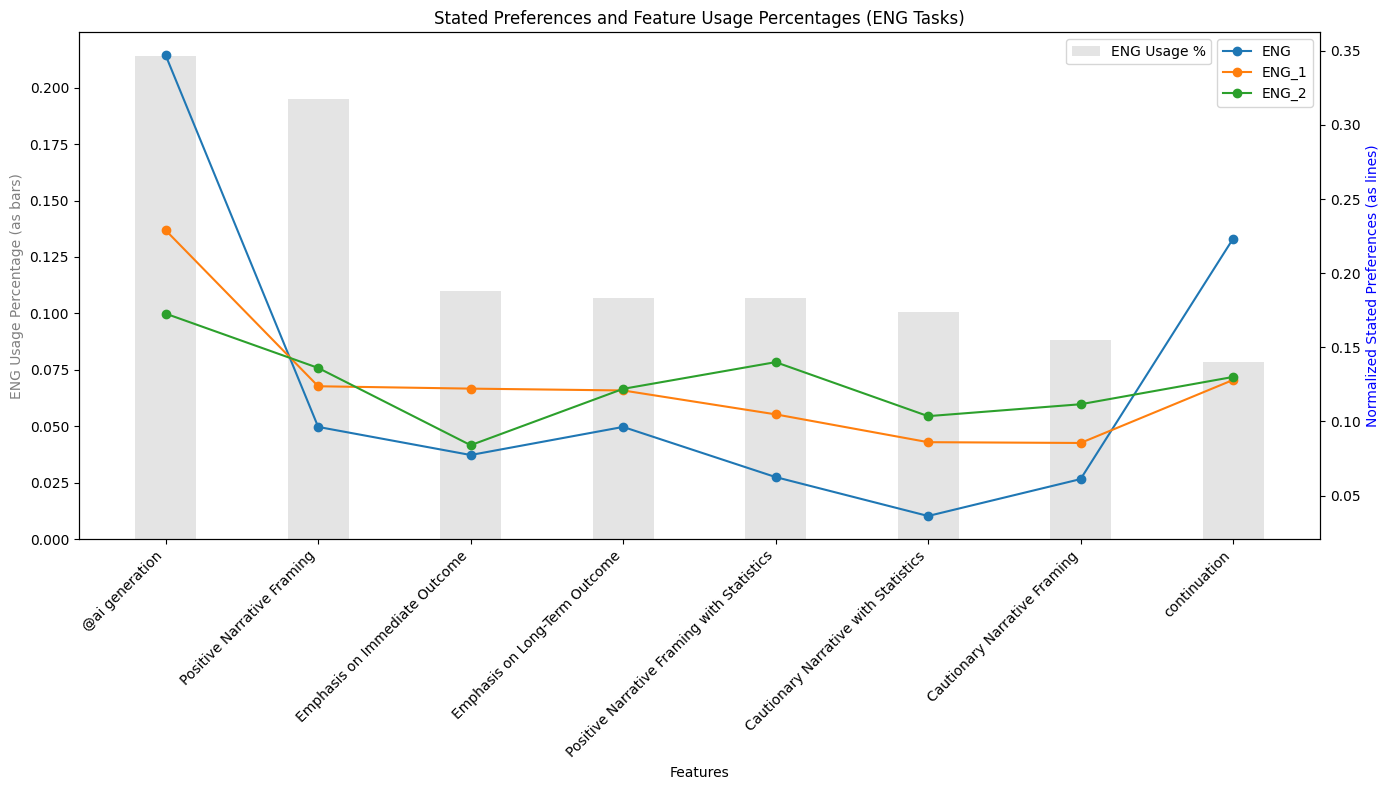

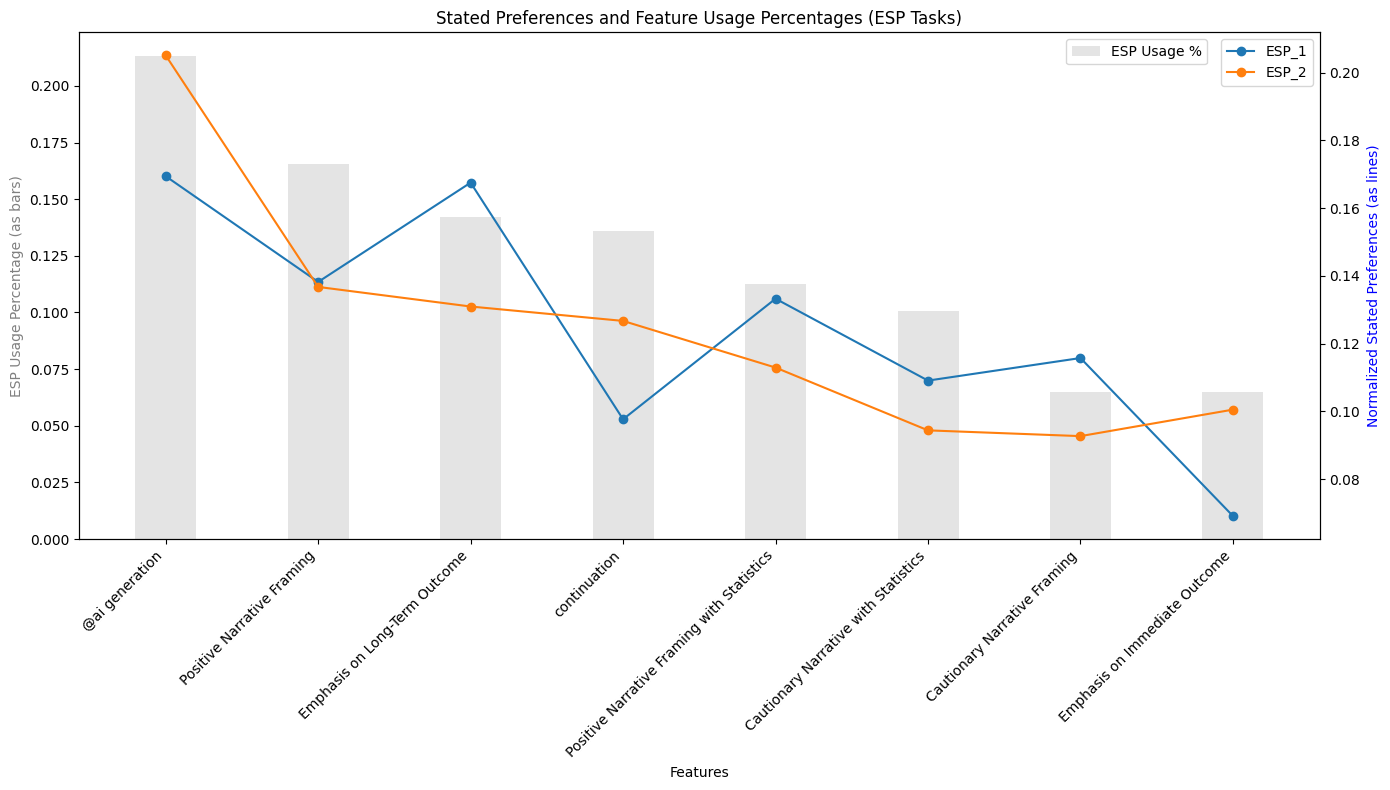

In [366]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for feature usage across ENG and ESP task groups
feature_usage_data = {
    'ENG': [30, 12, 11, 13, 18, 31, 15, 10],
    'ENG_1': [28, 9, 8, 12, 10, 21, 11, 7],
    'ENG_2': [10, 7, 13, 10, 6, 10, 8, 8],
    'ESP_1': [9, 5, 7, 7, 17, 14, 7, 8],
    'ESP_2': [27, 6, 10, 4, 7, 14, 12, 15]
}

features = ['@ai generation', 'Cautionary Narrative Framing', 'Cautionary Narrative with Statistics', 
            'Emphasis on Immediate Outcome', 'Emphasis on Long-Term Outcome', 
            'Positive Narrative Framing', 'Positive Narrative Framing with Statistics', 'continuation']

# Create a DataFrame for easier calculation
df_feature_usage = pd.DataFrame(feature_usage_data, index=features)

# Calculate total usage percentage for ENG-based tasks (ENG, ENG_1, ENG_2)
eng_total_usage = df_feature_usage[['ENG', 'ENG_1', 'ENG_2']].sum(axis=1)
eng_total_percentage = (eng_total_usage / eng_total_usage.sum()) * 100

# Sort by usage percentage (ENG)
eng_sorted_idx = eng_total_percentage.sort_values(ascending=False).index
eng_total_percentage_sorted = eng_total_percentage[eng_sorted_idx]

# Calculate total usage percentage for ESP-based tasks (ESP_1, ESP_2)
esp_total_usage = df_feature_usage[['ESP_1', 'ESP_2']].sum(axis=1)
esp_total_percentage = (esp_total_usage / esp_total_usage.sum()) * 100

# Sort by usage percentage (ESP)
esp_sorted_idx = esp_total_percentage.sort_values(ascending=False).index
esp_total_percentage_sorted = esp_total_percentage[esp_sorted_idx]

# Reorder stated_preferences_normalized_renamed to match sorted usage order
stated_preferences_normalized_ordered_eng = stated_preferences_normalized_renamed[eng_sorted_idx]
stated_preferences_normalized_ordered_esp = stated_preferences_normalized_renamed[esp_sorted_idx]

# Plot for ENG-based tasks
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bar chart for ENG percentage usage
bar_positions = np.arange(len(eng_total_percentage_sorted))
ax1.bar(bar_positions, eng_total_percentage_sorted / 100, color='lightgray', width=0.4, label='ENG Usage %', alpha=0.6)

# Set the x-tick labels to feature names
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(eng_total_percentage_sorted.index, rotation=45, ha='right')

# Plot the lines for normalized stated preferences (ENG-based)
ax2 = ax1.twinx()
for task_group in ['ENG', 'ENG_1', 'ENG_2']:
    ax2.plot(bar_positions, stated_preferences_normalized_ordered_eng.loc[task_group], marker='o', label=task_group)

# Set labels and title
ax1.set_xlabel('Features')
ax1.set_ylabel('ENG Usage Percentage (as bars)', color='gray')
ax2.set_ylabel('Normalized Stated Preferences (as lines)', color='blue')
plt.title('Stated Preferences and Feature Usage Percentages (ENG Tasks)')

# Combine legends from both plots
ax1.legend(loc='upper left', bbox_to_anchor=(0.79, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Tight layout for formatting
plt.tight_layout()

# Save the ENG plot
plt.savefig('../figures/results/eng_stated_preferences_and_usage_sorted.pdf', bbox_inches='tight')

plt.show()

# Plot for ESP-based tasks
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the bar chart for ESP percentage usage
bar_positions = np.arange(len(esp_total_percentage_sorted))
ax1.bar(bar_positions, esp_total_percentage_sorted / 100, color='lightgray', width=0.4, label='ESP Usage %', alpha=0.6)

# Set the x-tick labels to feature names
ax1.set_xticks(bar_positions)
ax1.set_xticklabels(esp_total_percentage_sorted.index, rotation=45, ha='right')

# Plot the lines for normalized stated preferences (ESP-based)
ax2 = ax1.twinx()
for task_group in ['ESP_1', 'ESP_2']:
    ax2.plot(bar_positions, stated_preferences_normalized_ordered_esp.loc[task_group], marker='o', label=task_group)

# Set labels and title
ax1.set_xlabel('Features')
ax1.set_ylabel('ESP Usage Percentage (as bars)', color='gray')
ax2.set_ylabel('Normalized Stated Preferences (as lines)', color='blue')
plt.title('Stated Preferences and Feature Usage Percentages (ESP Tasks)')

# Combine legends from both plots
ax1.legend(loc='upper left', bbox_to_anchor=(0.79, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Tight layout for formatting
plt.tight_layout()

# Save the ESP plot
plt.savefig('../figures/results/esp_stated_preferences_and_usage_sorted.pdf', bbox_inches='tight')

plt.show()


In [395]:
stated_preferences_normalized_ordered_eng.round(2)

,@ai generation,Positive Narrative Framing,Emphasis on Immediate Outcome,Emphasis on Long-Term Outcome,Positive Narrative Framing with Statistics,Cautionary Narrative with Statistics,Cautionary Narrative Framing,continuation
TASK_ID,,,,,,,,
ENG,0.35,0.10,0.08,0.10,0.06,0.04,0.06,0.22
ENG_1,0.23,0.12,0.12,0.12,0.10,0.09,0.09,0.13
ENG_2,0.17,0.14,0.08,0.12,0.14,0.10,0.11,0.13
ESP_1,0.17,0.14,0.07,0.17,0.13,0.11,0.12,0.10
ESP_2,0.21,0.14,0.10,0.13,0.11,0.09,0.09,0.13


In [ ]:
stated_preferences_normalized_ordered_eng

In [392]:
eng_total_percentage.reset_index().round(2).sort_values(0, ascending=False)

,index,0
0,@ai generation,21.38
5,Positive Narrative Framing,19.50
3,Emphasis on Immediate Outcome,11.01
4,Emphasis on Long-Term Outcome,10.69
6,Positive Narrative Framing with Statistics,10.69
2,Cautionary Narrative with Statistics,10.06
1,Cautionary Narrative Framing,8.81
7,continuation,7.86


In [393]:
esp_total_percentage.reset_index().round(2).sort_values(0, ascending=False)

,index,0
0,@ai generation,21.30
5,Positive Narrative Framing,16.57
4,Emphasis on Long-Term Outcome,14.20
7,continuation,13.61
6,Positive Narrative Framing with Statistics,11.24
2,Cautionary Narrative with Statistics,10.06
1,Cautionary Narrative Framing,6.51
3,Emphasis on Immediate Outcome,6.51


In [138]:
feature_usefulness_df =  final_survey_df[feature_cols + ['TASK_ID']].rename(columns=feat_to_full_name)
feature_usefulness_df

,Positive Narrative Framing,Cautionary Narrative Framing,Positive Narrative Framing with Statistics,Cautionary Narrative with Statistics,Emphasis on Immediate Outcome,Emphasis on Long-Term Outcome,@ai generation,continuation,TASK_ID
0,0,0,0,0,0,0,77,4,ENG
15,0,0,0,0,0,0,97,99,ENG
14,0,46,0,0,29,41,57,58,ENG
13,62,49,56,70,63,74,80,75,ENG
11,78,77,63,35,61,48,99,96,ENG
...,...,...,...,...,...,...,...,...,...
41,67,69,69,67,66,67,86,10,ESP_2
43,87,0,61,0,0,46,77,0,ESP_2
45,7,16,22,0,0,0,71,4,ESP_2
27,49,0,0,29,28,58,83,65,ESP_2


In [266]:
feature_usefulness_df.to_csv('./feature_usefulness_stated.csv',index=False)

In [169]:
grouped_feature_usage = feature_usefulness_df.groupby('TASK_ID').mean()
grouped_feature_usage

,Positive Narrative Framing,Cautionary Narrative Framing,Positive Narrative Framing with Statistics,Cautionary Narrative with Statistics,Emphasis on Immediate Outcome,Emphasis on Long-Term Outcome,@ai generation,continuation
TASK_ID,,,,,,,,
ENG,22.2500,14.1250,14.4375,8.3750,17.8750,22.2500,80.1250,51.5625
ENG_1,43.6875,30.1875,37.0000,30.3750,43.1250,42.6875,80.8125,45.1875
ENG_2,43.4375,35.6250,44.6875,33.0625,26.8125,38.9375,55.1250,41.5000
ESP_1,45.3750,38.0000,43.7500,35.8125,22.6875,55.0000,55.6250,32.0625
ESP_2,50.2500,34.0625,41.5000,34.6875,36.9375,48.1250,75.3750,46.5625


In [263]:
grouped_feature_usage = feature_usefulness_df.groupby('TASK_ID').agg(['mean','std']).round(2)
grouped_feature_usage

Positive Narrative Framing        Cautionary Narrative Framing         \
                              mean    std                         mean    std   
TASK_ID                                                                         
ENG                          22.25  35.77                        14.12  26.04   
ENG_1                        43.69  37.93                        30.19  35.24   
ENG_2                        43.44  41.51                        35.62  37.80   
ESP_1                        45.38  39.26                        38.00  35.70   
ESP_2                        50.25  34.07                        34.06  37.82   

        Positive Narrative Framing with Statistics         \
                                              mean    std   
TASK_ID                                                     
ENG                                          14.44  25.93   
ENG_1                                        37.00  41.02   
ENG_2                                        44.69  42.34   
ESP_1                                        43.75  41.66   
ESP_2                                        41.50  36.62   

        Cautionary Narrative with Statistics         \
                                        mean    std   
TASK_ID                                               
ENG                                     8.38  19.04   
ENG_1                                  30.38  37.38   
ENG_2                                  33.06  37.16   
ESP_1                                  35.81  38.97   
ESP_2                                  34.69  40.08   

        Emphasis on Immediate Outcome        Emphasis on Long-Term Outcome  \
                                 mean    std                          mean   
TASK_ID                                                                      
ENG                             17.88  25.41                         22.25   
ENG_1                           43.12  37.83                         42.69   
ENG_2                           26.81  36.32                         38.94   
ESP_1                           22.69  35.41                         55.00   
ESP_2                           36.94  38.61                         48.12   

               @ai generation        continuation         
           std           mean    std         mean    std  
TASK_ID                                                   
ENG      34.12          80.12  28.47        51.56  38.35  
ENG_1    36.73          80.81  28.50        45.19  38.73  
ENG_2    39.23          55.12  38.99        41.50  38.33  
ESP_1    32.45          55.62  42.79        32.06  37.59  
ESP_2    37.56          75.38  29.70        46.56  40.96

In [264]:
grouped_feature_usage.reset_index()

TASK_ID Positive Narrative Framing        Cautionary Narrative Framing  \
                                mean    std                         mean   
0     ENG                      22.25  35.77                        14.12   
1   ENG_1                      43.69  37.93                        30.19   
2   ENG_2                      43.44  41.51                        35.62   
3   ESP_1                      45.38  39.26                        38.00   
4   ESP_2                      50.25  34.07                        34.06   

         Positive Narrative Framing with Statistics         \
     std                                       mean    std   
0  26.04                                      14.44  25.93   
1  35.24                                      37.00  41.02   
2  37.80                                      44.69  42.34   
3  35.70                                      43.75  41.66   
4  37.82                                      41.50  36.62   

  Cautionary Narrative with Statistics        Emphasis on Immediate Outcome  \
                                  mean    std                          mean   
0                                 8.38  19.04                         17.88   
1                                30.38  37.38                         43.12   
2                                33.06  37.16                         26.81   
3                                35.81  38.97                         22.69   
4                                34.69  40.08                         36.94   

         Emphasis on Long-Term Outcome        @ai generation         \
     std                          mean    std           mean    std   
0  25.41                         22.25  34.12          80.12  28.47   
1  37.83                         42.69  36.73          80.81  28.50   
2  36.32                         38.94  39.23          55.12  38.99   
3  35.41                         55.00  32.45          55.62  42.79   
4  38.61                         48.12  37.56          75.38  29.70   

  continuation         
          mean    std  
0        51.56  38.35  
1        45.19  38.73  
2        41.50  38.33  
3        32.06  37.59  
4        46.56  40.96

In [252]:
grouped_feature_usage.to_csv('usefulness_mean_std.csv',index=False)

In [ ]:
grouped_feature_usage

In [163]:
percentage_feature_usage['y_tick_label'] = (
    percentage_feature_usage['feature_filtered'] 
    + ' (' 
    + percentage_feature_usage['percentage'].round(2).astype(str) 
    + '%)'
)

In [164]:
percentage_feature_usage

,feature_filtered,percentage,y_tick_label
0,@ai generation,21.355236,@ai generation (21.36%)
5,Positive Narrative Framing,18.480493,Positive Narrative Framing (18.48%)
4,Emphasis on Long-Term Outcome,11.909651,Emphasis on Long-Term Outcome (11.91%)
6,Positive Narrative Framing with Statistics,10.882957,Positive Narrative Framing with Statistics (10...
2,Cautionary Narrative with Statistics,10.061602,Cautionary Narrative with Statistics (10.06%)
7,continuation,9.856263,continuation (9.86%)
3,Emphasis on Immediate Outcome,9.445585,Emphasis on Immediate Outcome (9.45%)
1,Cautionary Narrative Framing,8.008214,Cautionary Narrative Framing (8.01%)


In [158]:
percentage_feature_usage['y_label'] = features_with_percentage

['Positive Narrative Framing\n(18.48%)',
 'Cautionary Narrative Framing\n(8.01%)',
 'Positive Narrative Framing with Statistics\n(10.88%)',
 'Cautionary Narrative with Statistics\n(10.06%)',
 'Emphasis on Immediate Outcome\n(9.45%)',
 'Emphasis on Long-Term Outcome\n(11.91%)',
 '@ai generation\n(21.36%)',
 'continuation\n(9.86%)']

In [171]:
grouped_feature_usage

,Positive Narrative Framing,Cautionary Narrative Framing,Positive Narrative Framing with Statistics,Cautionary Narrative with Statistics,Emphasis on Immediate Outcome,Emphasis on Long-Term Outcome,@ai generation,continuation
TASK_ID,,,,,,,,
ENG,22.2500,14.1250,14.4375,8.3750,17.8750,22.2500,80.1250,51.5625
ENG_1,43.6875,30.1875,37.0000,30.3750,43.1250,42.6875,80.8125,45.1875
ENG_2,43.4375,35.6250,44.6875,33.0625,26.8125,38.9375,55.1250,41.5000
ESP_1,45.3750,38.0000,43.7500,35.8125,22.6875,55.0000,55.6250,32.0625
ESP_2,50.2500,34.0625,41.5000,34.6875,36.9375,48.1250,75.3750,46.5625


In [177]:
# Provided DataFrames
grouped_feature_usage = pd.DataFrame({
    'Positive Narrative Framing': [22.25, 43.6875, 43.4375, 45.375, 50.25],
    'Cautionary Narrative Framing': [14.125, 30.1875, 35.625, 38, 34.0625],
    'Positive Narrative Framing with Statistics': [14.4375, 37, 44.6875, 43.75, 41.5],
    'Cautionary Narrative with Statistics': [8.375, 30.375, 33.0625, 35.8125, 34.6875],
    'Emphasis on Immediate Outcome': [17.875, 43.125, 26.8125, 22.6875, 36.9375],
    'Emphasis on Long-Term Outcome': [22.25, 42.6875, 38.9375, 55, 48.125],
    '@ai generation': [80.125, 80.8125, 55.125, 55.625, 75.375],
    'continuation': [51.5625, 45.1875, 41.5, 32.0625, 46.5625],
}, index=['ENG', 'ENG_1', 'ENG_2', 'ESP_1', 'ESP_2'])

percentage_feature_usage = pd.DataFrame({
    'feature_filtered': [
        '@ai generation', 'Positive Narrative Framing', 'Emphasis on Long-Term Outcome',
        'Positive Narrative Framing with Statistics', 'Cautionary Narrative with Statistics', 
        'continuation', 'Emphasis on Immediate Outcome', 'Cautionary Narrative Framing'
    ],
    'percentage': [21.355236, 18.480493, 11.909651, 10.882957, 10.061602, 9.856263, 9.445585, 8.008214],
    'y_tick_label': [
        '@ai generation (21.36%)', 'Positive Narrative Framing (18.48%)', 'Emphasis on Long-Term Outcome (11.91%)',
        'Positive Narrative Framing with Statistics (10.88%)', 'Cautionary Narrative with Statistics (10.06%)', 
        'continuation (9.86%)', 'Emphasis on Immediate Outcome (9.45%)', 'Cautionary Narrative Framing (8.01%)'
    ]
})




In [181]:
# Sort columns based on percentage in descending order
sorted_features = percentage_feature_usage.sort_values(by='percentage', ascending=False)

# Rearrange the columns of grouped_feature_usage based on sorted features
grouped_feature_usage_sorted = grouped_feature_usage[sorted_features['feature_filtered'].values]

# Rename the columns to their y_tick_label counterparts
grouped_feature_usage_sorted.columns = sorted_features['y_tick_label'].values

In [182]:
fig = px.imshow(
    grouped_feature_usage_sorted.T,
    labels=dict(x="Task ID", y="Features", color="Usage"),
    color_continuous_scale="YlGnBu",
    aspect="auto",
    text_auto=True
)

# Update layout and axis labels


In [262]:
fig = px.imshow(grouped_feature_usage_sorted.T, 
                labels=dict(x="Task ID", y="Features", color="Usage"),
                # x=heatmap_data.columns,
                # y=heatmap_data.index,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# # Adjust the figure size to match the Seaborn plot
fig.update_layout(title="Heatmap of Feature Counts by Task ID",
                  xaxis_title="Task ID",
                  yaxis_title="Features",
                  width=1200,  # Set width to match Seaborn
                  height=800,  # Set height to match Seaborn
                  margin=dict(l=80, r=80, t=100, b=80))  # Adjust margi

fig.update_layout(
    title="Heatmap of Feature Usage by Task ID with Percentage Labels",
    xaxis_title="Task ID",
    yaxis_title="Features",
    yaxis_tickangle=-45
)

fig.write_image("../figures/results/stage2_usefulness_with_count.pdf")

fig.show()

In [257]:
# Provided DataFrames
grouped_feature_usage = pd.DataFrame({
    'Positive Narrative Framing': [22.25, 43.6875, 43.4375, 45.375, 50.25],
    'Cautionary Narrative Framing': [14.125, 30.1875, 35.625, 38, 34.0625],
    'Positive Narrative Framing with Statistics': [14.4375, 37, 44.6875, 43.75, 41.5],
    'Cautionary Narrative with Statistics': [8.375, 30.375, 33.0625, 35.8125, 34.6875],
    'Emphasis on Immediate Outcome': [17.875, 43.125, 26.8125, 22.6875, 36.9375],
    'Emphasis on Long-Term Outcome': [22.25, 42.6875, 38.9375, 55, 48.125],
    '@ai generation': [80.125, 80.8125, 55.125, 55.625, 75.375],
    'continuation': [51.5625, 45.1875, 41.5, 32.0625, 46.5625],
}, index=['ENG', 'ENG_1', 'ENG_2', 'ESP_1', 'ESP_2'])

percentage_feature_usage = pd.DataFrame({
    'feature_filtered': [
        '@ai generation', 'Positive Narrative Framing', 'Emphasis on Long-Term Outcome',
        'Positive Narrative Framing with Statistics', 'Cautionary Narrative with Statistics', 
        'continuation', 'Emphasis on Immediate Outcome', 'Cautionary Narrative Framing'
    ],
    'percentage': [21.355236, 18.480493, 11.909651, 10.882957, 10.061602, 9.856263, 9.445585, 8.008214],
    'y_tick_label': [
        '@ai generation (21.36%)', 'Positive Narrative Framing (18.48%)', 'Emphasis on Long-Term Outcome (11.91%)',
        'Positive Narrative Framing with Statistics (10.88%)', 'Cautionary Narrative with Statistics (10.06%)', 
        'continuation (9.86%)', 'Emphasis on Immediate Outcome (9.45%)', 'Cautionary Narrative Framing (8.01%)'
    ]
})

# Separate ENG and ESP groups
grouped_feature_usage_eng = grouped_feature_usage.loc[['ENG', 'ENG_1', 'ENG_2']]
grouped_feature_usage_esp = grouped_feature_usage.loc[['ESP_1', 'ESP_2']]

# Sort columns based on percentage in descending order for both groups
sorted_features = percentage_feature_usage.sort_values(by='percentage', ascending=False)

# Rearrange the columns of both DataFrames based on sorted features
grouped_feature_usage_eng_sorted = grouped_feature_usage_eng[sorted_features['feature_filtered'].values]
grouped_feature_usage_esp_sorted = grouped_feature_usage_esp[sorted_features['feature_filtered'].values]

# Rename the columns to their y_tick_label counterparts for both groups
grouped_feature_usage_eng_sorted.columns = sorted_features['y_tick_label'].values
grouped_feature_usage_esp_sorted.columns = sorted_features['y_tick_label'].values

# Output the separated DataFrames
# grouped_feature_usage_eng_sorted, grouped_feature_usage_esp_sorted


In [260]:
fig = px.imshow(grouped_feature_usage_eng_sorted.T, 
                labels=dict(x="Task ID", y="Features", color="Usage"),
                # x=heatmap_data.columns,
                # y=heatmap_data.index,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# # Adjust the figure size to match the Seaborn plot
fig.update_layout(title="Heatmap of Feature Counts by Task ID",
                  xaxis_title="Task ID",
                  yaxis_title="Features",
                  width=1200,  # Set width to match Seaborn
                  height=800,  # Set height to match Seaborn
                  margin=dict(l=80, r=80, t=100, b=80))  # Adjust margi

fig.update_layout(
    title="Heatmap of Feature Usage by Task ID with Percentage Labels",
    xaxis_title="Task ID",
    yaxis_title="Features"
)

fig.write_image("../figures/results/stage2_usefulness_with_count_eng.pdf")

fig.show()

In [259]:
fig = px.imshow(grouped_feature_usage_esp_sorted.T, 
                labels=dict(x="Task ID", y="Features", color="Usage"),
                # x=heatmap_data.columns,
                # y=heatmap_data.index,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# # Adjust the figure size to match the Seaborn plot
fig.update_layout(title="Heatmap of Feature Counts by Task ID",
                  xaxis_title="Task ID",
                  yaxis_title="Features",
                  width=1200,  # Set width to match Seaborn
                  height=800,  # Set height to match Seaborn
                  margin=dict(l=80, r=80, t=100, b=80))  # Adjust margi

fig.update_layout(
    title="Heatmap of Feature Usage by Task ID with Percentage Labels",
    xaxis_title="Task ID",
    yaxis_title="Features"
)

fig.write_image("../figures/results/stage2_usefulness_with_count_esp.pdf")

fig.show()

# Revelaed Utility: Content similarity

In [186]:
content_usage = pd.read_csv('../output/paper_output/stag1_embedding_master.csv')

In [187]:
avg_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'average_similarity_SentenceTransformer',
        'average_similarity_nomic-embed-text',
        'average_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Average Similarity (%)'
)

# Melt the DataFrame to long format for weighted average similarity
weighted_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'weighted_similarity_SentenceTransformer',
        'weighted_similarity_nomic-embed-text',
        'weighted_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Weighted Average Similarity (%)'
)

# Clean up the 'Model' column to only contain the model names

avg_similarity_df['Model'] = avg_similarity_df['Model'].str.replace('average_similarity_', '')
weighted_similarity_df['Model'] = weighted_similarity_df['Model'].str.replace('weighted_similarity_', '')


avg_similarity_df =  avg_similarity_df[avg_similarity_df['TASK_ID']!='ENG_No_LLM']
weighted_similarity_df =  weighted_similarity_df[weighted_similarity_df['TASK_ID']!='ENG_No_LLM']

avg_similarity_df = avg_similarity_df.groupby(['TASK_ID','Model'])['Average Similarity (%)'].mean().reset_index()
weighted_similarity_df = weighted_similarity_df.groupby(['TASK_ID','Model'])['Weighted Average Similarity (%)'].mean().reset_index()

# Step 2: Plot using Plotly

# Plot Average Similarity
fig_avg = px.bar(
    avg_similarity_df,
    x='TASK_ID',
    y='Average Similarity (%)',
    color='Model',
    title='Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group',
    color_discrete_sequence=hex_pal
)
fig_avg.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_avg.show()
fig_avg.write_image('../figures/results/content_similarity_avg.pdf')
# Plot Weighted Average Similarity
fig_weighted = px.bar(
    weighted_similarity_df,
    x='TASK_ID',
    y='Weighted Average Similarity (%)',
    color='Model',
    title='Weighted Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group',
    color_discrete_sequence=hex_pal
)
fig_weighted.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Weighted Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_weighted.show()
fig_weighted.write_image('../figures/results/content_similarity_weighted.pdf')


In [396]:
import plotly.express as px

# Plot Weighted Average Similarity as a trend line chart
fig_weighted_trend = px.line(
    weighted_similarity_df,
    x='TASK_ID',
    y='Weighted Average Similarity (%)',
    color='Model',
    title='Weighted Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    markers=True,  # Add markers to emphasize data points
    color_discrete_sequence=hex_pal  # Using the same color palette
)

# Update the layout for aesthetics
fig_weighted_trend.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Weighted Average Similarity Percentage (%)',
    width=900,
    height=600
)

# Show the figure
fig_weighted_trend.show()

# Save the chart as a PDF
fig_weighted_trend.write_image('../figures/results/content_similarity_weighted_trend.pdf')


# Stage 2: participants

In [302]:
stage2_cw = pd.read_csv(os.path.join(results_path,'stage2_participant.csv'))

In [303]:
stage2_cw.head(1)

,Unnamed: 0,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,...,Total approvals,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status
0,3,66d8ba7c1586565023d7d1ad,665221f0996f9daef629b186,AWAITING REVIEW,Not Applicable,2024-09-04T19:53:56.951000Z,2024-09-04T19:57:41.568000Z,NaN,2024-09-04T19:57:42.320906Z,225.0,...,10,45,Female,Asian,United States,United States,United States,English,No,"Not in paid work (e.g. homemaker', 'retired or..."


In [305]:
stage2_cw['Age'].describe().round(2)

count    720.00
mean      36.84
std       12.43
min       18.00
25%       27.00
50%       34.00
75%       45.00
max       82.00
Name: Age, dtype: float64

In [308]:
stage2_cw['Sex'].value_counts(normalize=True).round(2)*100

Sex
Female               57.0
Male                 42.0
Prefer not to say     1.0
DATA_EXPIRED          0.0
Name: proportion, dtype: float64

In [310]:
stage2_cw.shape

(720, 21)

# Stage 2: Donations

In [397]:
donation_data = pd.read_csv('../output/paper_output/stage2_donation_final_filtered.csv')
donation_data.head(1)

,PROLIFIC_PID,document_id,task_id,task_category,timestamp,donation_data,attentionCheck,charityFeedbackPositive,charityFeedbackNegative,adSource,adSourceReason,recipeUsed,EA1,EA2,EA3,IA1,IA2,IA3,BI1,BI2
0,607778a26ff3de83125f50c5,66c5a13c86c57a87db6f59d9,ENG,ENG,{'$date': '2024-09-04T18:46:18.789Z'},0.0,WWF,NaN,NaN,AS1,It seems generic.,['RU2'],1,1,1,4,3,3,2,2


In [398]:
donation_data['task_id'].value_counts()

task_id
ENG            80
ESP_2          80
ENG_1          80
ESP_1          80
ENG_2          80
ENG_No_LLM     80
ENG_LLM        80
CONTROL_ENG    80
ESP_LLM        80
Name: count, dtype: int64

In [279]:
donation_data[donation_data['PROLIFIC_PID']=='65e18d62c5a884a634501922']

,PROLIFIC_PID,document_id,task_id,task_category,timestamp,donation_data,attentionCheck,charityFeedbackPositive,charityFeedbackNegative,adSource,adSourceReason,recipeUsed,EA1,EA2,EA3,IA1,IA2,IA3,BI1,BI2


In [206]:
donation_data = donation_data[donation_data['PROLIFIC_PID']!='65e18d62c5a884a634501922']

In [148]:
donation_data.to_csv('../output/paper_output/stage2_donation_final.csv', index=False)

In [280]:
donation_data['task_id'].value_counts()

task_id
ENG            80
ESP_2          80
ENG_1          80
ESP_1          80
ENG_2          80
ENG_No_LLM     80
ENG_LLM        80
CONTROL_ENG    80
ESP_LLM        80
Name: count, dtype: int64

In [399]:
scale_mapping = {
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5,
    "Totalmente en desacuerdo": 1,
    "En desacuerdo": 2,
    "Neutral": 3,
    "De acuerdo": 4,
    "Totalmente de acuerdo": 5
}

categories = {
    "emotionalAppeal": ["EA1", "EA2", "EA3"],
    "informationAwareness": ["IA1", "IA2", "IA3"],
    "behavioralIntentions": ["BI1", "BI2"],
}

In [400]:
donation_data.sort_values('task_id', inplace=True)

## Emotional Appeal

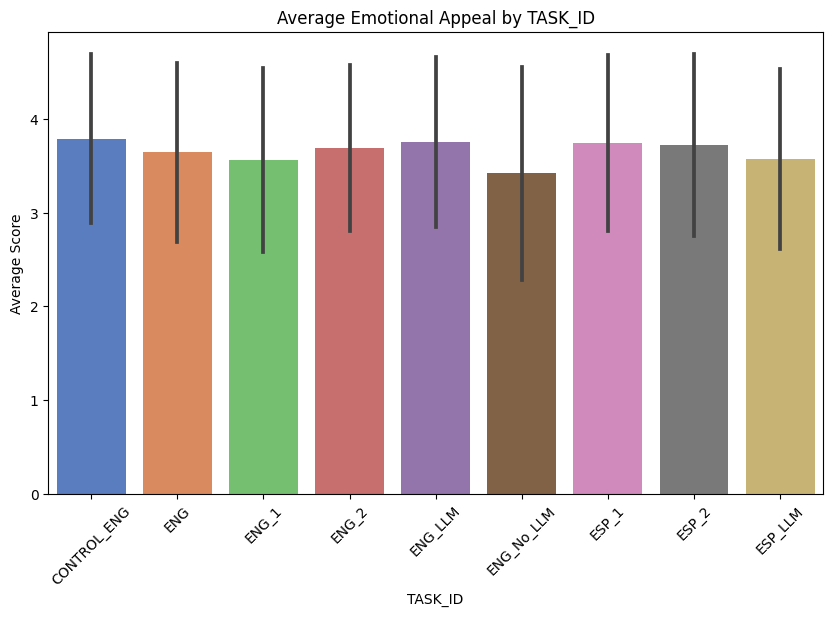

In [403]:
emotional_appeal_df = donation_data[categories['emotionalAppeal'] + ['task_id']].copy()

# Calculate the average emotional appeal score across the columns
emotional_appeal_df['emotionalAppeal'] = emotional_appeal_df[categories['emotionalAppeal']].mean(axis=1)

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=emotional_appeal_df, x='task_id', y='emotionalAppeal', errorbar='sd', palette='muted')

# Labeling the plot
plt.title('Average Emotional Appeal by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)

plt.savefig('../figures/results/stage2_ea.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Information Awareness

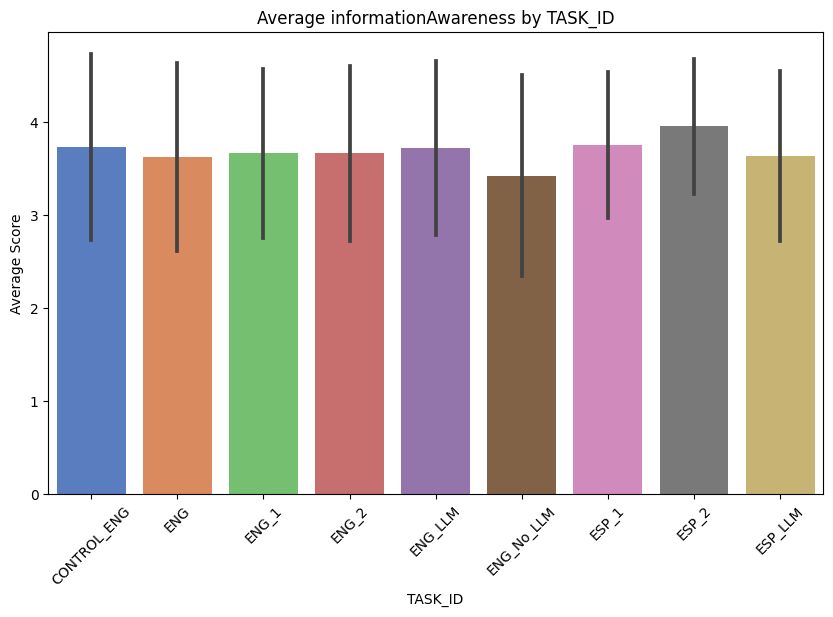

In [404]:
informationAwareness_df = donation_data[categories['informationAwareness'] + ['task_id']].copy()

# Calculate the average emotional appeal score across the columns
informationAwareness_df['informationAwareness'] = informationAwareness_df[categories['informationAwareness']].mean(axis=1)

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=informationAwareness_df, x='task_id', y='informationAwareness', errorbar='sd', palette='muted')

# Labeling the plot
plt.title('Average informationAwareness by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)
plt.savefig('../figures/results/stage2_ia.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Behavioural Intentions

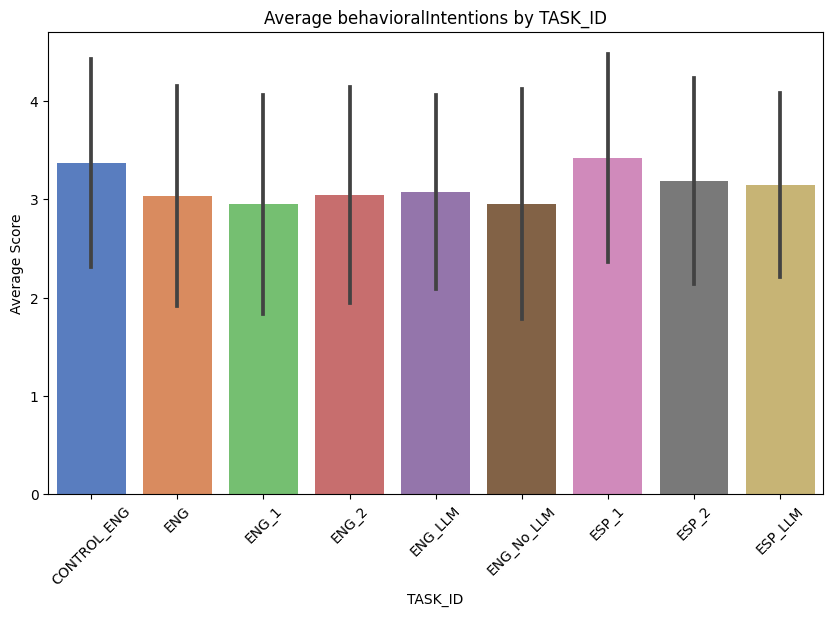

In [405]:
behavioralIntentions_df = donation_data[categories['behavioralIntentions'] + ['task_id']].copy()

# Calculate the average emotional appeal score across the columns
behavioralIntentions_df['behavioralIntentions'] = behavioralIntentions_df[categories['behavioralIntentions']].mean(axis=1)

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=behavioralIntentions_df, x='task_id', y='behavioralIntentions', errorbar='sd', palette='muted')

# Labeling the plot
plt.title('Average behavioralIntentions by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)

plt.savefig('../figures/results/stage2_bi.pdf', bbox_inches='tight')

# Show the plot
plt.show()

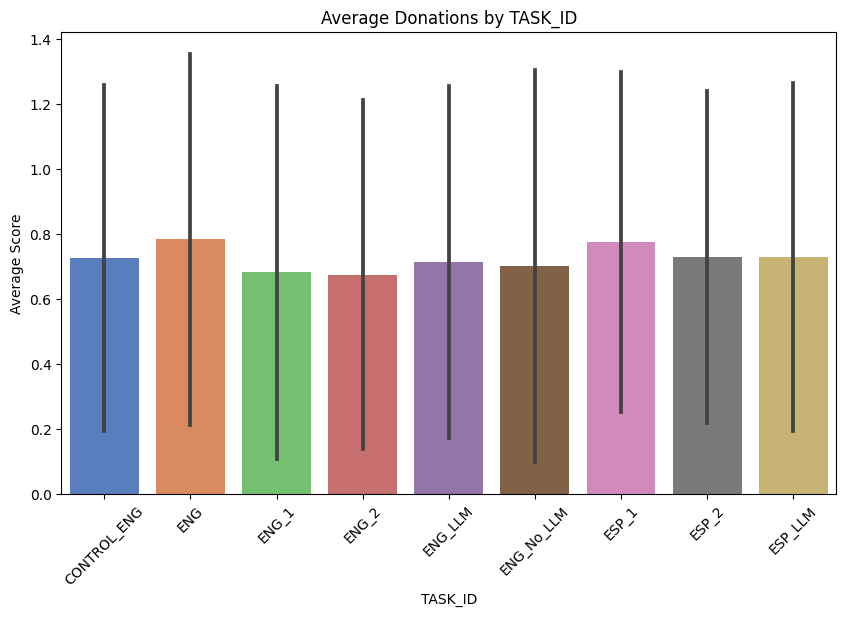

In [406]:

donation_data['donation_data'] = donation_data['donation_data'].astype(float)
# grouped_df_cat = df[['donation_data','task_id']].groupby('task_id').mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x=donation_data['task_id'], y=donation_data['donation_data'], errorbar='sd', palette='muted')
plt.title('Average Donations by TASK_ID')
plt.ylabel('Average Score')
plt.xlabel('TASK_ID')
plt.xticks(rotation=45)
plt.savefig('../figures/results/stage2_donation.pdf', bbox_inches='tight')

plt.show()

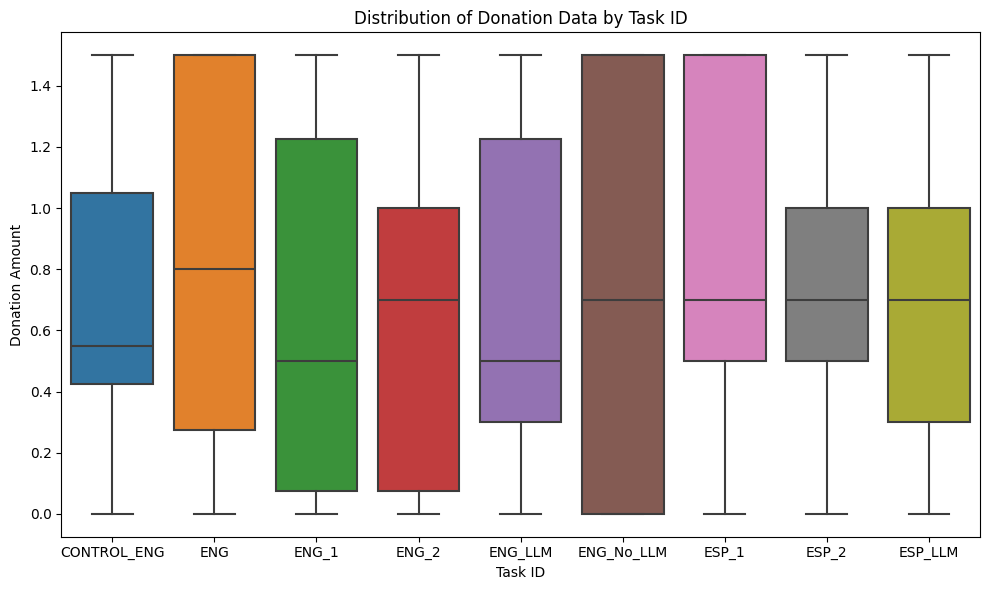

In [407]:
# Plot the distribution of donation data for each task_id using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='task_id', y='donation_data', data=donation_data.sort_values(by='task_id'))

plt.title('Distribution of Donation Data by Task ID')
plt.ylabel('Donation Amount')
plt.xlabel('Task ID')
plt.tight_layout()
plt.savefig('../figures/results/stage2_donation.pdf', bbox_inches='tight')

plt.show()


In [232]:
donation_data['donation_data'].describe()

count    708.000000
mean       0.725989
std        0.543864
min        0.000000
25%        0.200000
50%        0.700000
75%        1.125000
max        1.500000
Name: donation_data, dtype: float64

In [440]:
donation_data.groupby('task_id')['donation_data'].agg(['std','mean','median']).reset_index().round(2)

,task_id,std,mean,median
0,CONTROL_ENG,0.53,0.73,0.55
1,ENG,0.57,0.78,0.80
2,ENG_1,0.58,0.68,0.50
3,ENG_2,0.54,0.68,0.70
4,ENG_LLM,0.54,0.71,0.50
5,ENG_No_LLM,0.60,0.70,0.70
6,ESP_1,0.52,0.78,0.70
7,ESP_2,0.51,0.73,0.70
8,ESP_LLM,0.54,0.73,0.70


In [434]:
low_donation_count = donation_data[donation_data['donation_data']==0]['task_id'].value_counts().div(donation_data[donation_data['donation_data']==0]['task_id'].value_counts().sum()).round(2).reset_index()
low_donation_count = low_donation_count.sort_values('task_id')
low_donation_count

,task_id,count
7,CONTROL_ENG,0.08
3,ENG,0.11
1,ENG_1,0.13
2,ENG_2,0.13
5,ENG_LLM,0.10
0,ENG_No_LLM,0.16
8,ESP_1,0.08
6,ESP_2,0.10
4,ESP_LLM,0.11


In [433]:
high_donation_count = donation_data[donation_data['donation_data']==1.5]['task_id'].value_counts().div(donation_data[donation_data['donation_data']==1.5]['task_id'].value_counts().sum()).round(2).reset_index()
high_donation_count = high_donation_count.sort_values('task_id')
high_donation_count

,task_id,count
4,CONTROL_ENG,0.11
0,ENG,0.14
3,ENG_1,0.11
8,ENG_2,0.08
5,ENG_LLM,0.10
1,ENG_No_LLM,0.13
2,ESP_1,0.13
7,ESP_2,0.09
6,ESP_LLM,0.10


In [422]:
donation_data.groupby('task_id')['donation_data'].mean()

task_id
CONTROL_ENG    0.72750
ENG            0.78375
ENG_1          0.68250
ENG_2          0.67500
ENG_LLM        0.71375
ENG_No_LLM     0.70250
ESP_1          0.77625
ESP_2          0.73000
ESP_LLM        0.73000
Name: donation_data, dtype: float64

In [412]:
# Define bins based on the donation data value ranges
bins = [0, 0.5, 1.0, 1.5, 2.0]
bin_labels = ['0-0.5', '0.5-1.0', '1.0-1.5', '1.5']
# Define bins based on the donation data value ranges


# Copy relevant columns explicitly using .loc to avoid the SettingWithCopyWarning
donation_data_percentiles = donation_data.loc[:, ['task_id', 'donation_data']].copy()

# Add a new column for donation categories based on the bins
donation_data_percentiles.loc[:, 'donation_category'] = pd.cut(donation_data_percentiles['donation_data'], bins=bins, labels=bin_labels, right=False)

# Group by task_id and donation category, with observed=True to avoid the FutureWarning
donation_category_distribution = donation_data_percentiles.groupby(['task_id', 'donation_category'], observed=True).size().unstack(fill_value=0)

# Calculate the percentage of donations in each category by task_id
donation_category_percentage = donation_category_distribution.div(donation_category_distribution.sum(axis=1), axis=0) * 100

# Reset index and melt for easier plotting
donation_category_percentage_reset = donation_category_percentage.reset_index()
donation_melted = donation_category_percentage_reset.melt(id_vars="task_id", var_name="Donation Category", value_name="Percentage")

# Display the result to the user
donation_melted

,task_id,Donation Category,Percentage
0,CONTROL_ENG,0-0.5,25.00
1,ENG,0-0.5,26.25
2,ENG_1,0-0.5,35.00
3,ENG_2,0-0.5,33.75
4,ENG_LLM,0-0.5,31.25
5,ENG_No_LLM,0-0.5,36.25
6,ESP_1,0-0.5,18.75
7,ESP_2,0-0.5,23.75
8,ESP_LLM,0-0.5,26.25
9,CONTROL_ENG,0.5-1.0,35.00


In [418]:
# Create a bar plot using Plotly
fig = px.bar(donation_melted, 
             x='task_id', 
             y='Percentage', 
             color='Donation Category', 
             barmode='group', 
             title='Donation Category Distribution by Task ID',
             color_discrete_sequence=hex_pal,
            #  aspect='auto',
             labels={'task_id': 'Task ID', 'Percentage': 'Percentage of Donations'})

# Update layout for better visualization
fig.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Percentage of Donations',
    legend_title='Donation Category',
    template='plotly'
)

fig.write_image('../figures/results/percentage_donation_bin.pdf')
# Show the plot
fig.show()


# Ad source

In [236]:
adsource = donation_data.groupby(['task_id'])['adSource'].value_counts().reset_index()

adsource_config = {
    "AS1": "AI",
    "AS2": "Human",
}
adsource['adSource']= adsource['adSource'].map(lambda x: adsource_config.get(x))

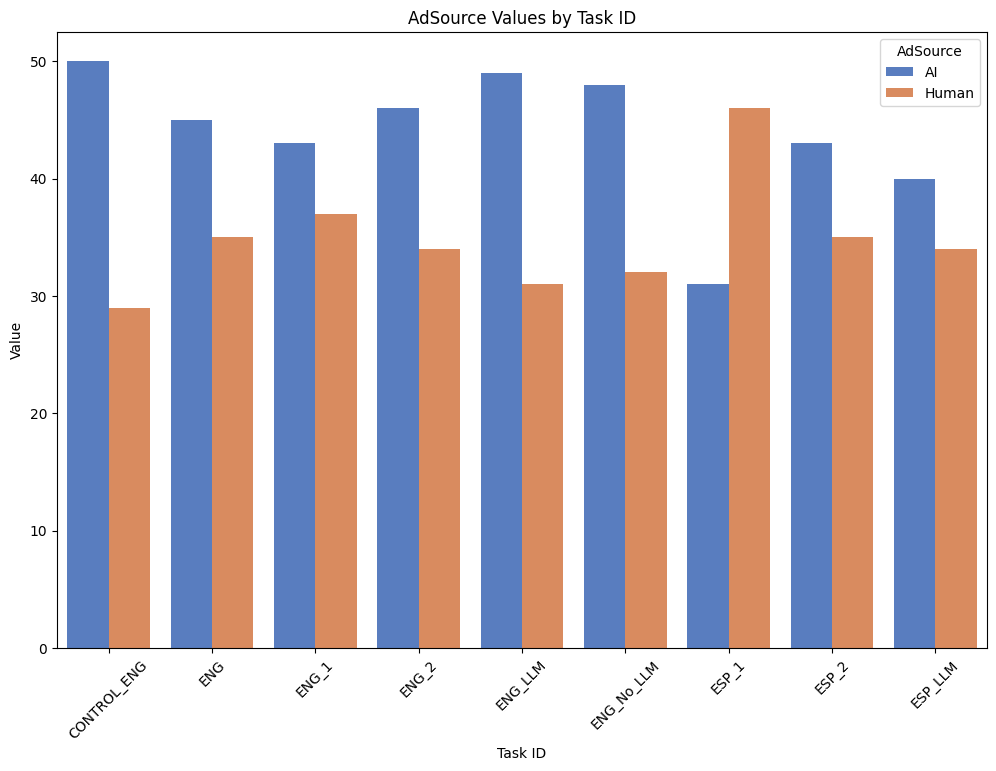

In [237]:
plt.figure(figsize=(12, 8))
sns.barplot(x='task_id', y='count', hue='adSource', data=adsource, palette='muted')

# Customize the plot
plt.title('AdSource Values by Task ID')
plt.ylabel('Value')
plt.xlabel('Task ID')
plt.xticks(rotation=45)
plt.legend(title='AdSource')

# Show the plot
plt.show()

# Donation Task: Recipes Used

In [238]:
donation_data['recipeUsed'] = donation_data['recipeUsed'].apply(ast.literal_eval)

In [239]:
recipeUsed = donation_data.groupby('task_id')['recipeUsed'].sum().reset_index()
recipeUsed['recipeUsed_count'] = recipeUsed['recipeUsed'].apply(lambda x: dict(Counter(x)))
recipeUsed

,task_id,recipeUsed,recipeUsed_count
0,CONTROL_ENG,"[RU7, RU7, RU7, RU7, RU5, RU6, RU1, RU7, RU5, ...","{'RU7': 39, 'RU5': 19, 'RU6': 23, 'RU1': 16, '..."
1,ENG,"[RU3, RU3, RU3, RU3, RU5, RU6, RU7, RU3, RU6, ...","{'RU3': 19, 'RU5': 32, 'RU6': 30, 'RU7': 13, '..."
2,ENG_1,"[RU2, RU1, RU6, RU1, RU3, RU3, RU1, RU7, RU1, ...","{'RU2': 11, 'RU1': 21, 'RU6': 24, 'RU3': 17, '..."
3,ENG_2,"[RU3, RU5, RU1, RU1, RU3, RU5, RU1, RU3, RU2, ...","{'RU3': 20, 'RU5': 22, 'RU1': 24, 'RU2': 8, 'R..."
4,ENG_LLM,"[RU7, RU7, RU6, RU6, RU5, RU6, RU6, RU5, RU6, ...","{'RU7': 14, 'RU6': 47, 'RU5': 26, 'RU3': 10, '..."
5,ENG_No_LLM,"[RU7, RU7, RU7, RU7, RU2, RU3, RU2, RU7, RU1, ...","{'RU7': 31, 'RU2': 12, 'RU3': 6, 'RU1': 11, 'R..."
6,ESP_1,"[RU1, RU6, RU5, RU6, RU7, RU1, RU5, RU6, RU1, ...","{'RU1': 37, 'RU6': 31, 'RU5': 37, 'RU7': 10, '..."
7,ESP_2,"[RU6, RU1, RU2, RU5, RU2, RU6, RU5, RU5, RU6, ...","{'RU6': 31, 'RU1': 20, 'RU2': 15, 'RU5': 30, '..."
8,ESP_LLM,"[RU3, RU7, RU7, RU1, RU6, RU5, RU6, RU1, RU4, ...","{'RU3': 13, 'RU7': 21, 'RU1': 18, 'RU6': 28, '..."


In [240]:
ru_mapping = {
    'RU1': "A positive story about how donations have helped others.",
    'RU2': "A warning story about what can happen without donations.",
    'RU3': "Numbers showing the positive impact of donations.",
    'RU4': "Numbers highlighting the negative consequences of not donating.",
    'RU5': "How donations can make a difference right away.",
    'RU6': "How donations will help in the long run.",
    'RU7': "None of the Above"
}

In [241]:
counts_df = pd.DataFrame(recipeUsed['recipeUsed_count'].tolist()).fillna(0).astype(int)

# Add the 'task_id' back to the counts DataFrame
counts_df['task_id'] = recipeUsed['task_id']

# Set the task_id as the index for easier plotting
counts_df.set_index('task_id', inplace=True)

counts_df.rename(columns=ru_mapping, inplace=True)

In [244]:
fig = px.imshow(counts_df.T, 
                labels=dict(x="Task ID", y="Donation Story", color="Count"),
                x=counts_df.index,
                y=counts_df.columns,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# Show the plot
fig.show()